In [1]:
# Load web scraping tools
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException, WebDriverException
from webdriver_manager.chrome import ChromeDriverManager
import matplotlib.pyplot as plt

from afinn import Afinn
import pandas as pd
import numpy as np
import os
import time as Time
import math
import difflib
import re

### Fetch Stocks' articles (Webscraping)
(use finance.yahoo.com)

In [2]:
# Get web driver
options = webdriver.ChromeOptions()
options.add_argument("--enable-javascript")
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)

C:\Users\24399\AppData\Local\Temp\ipykernel_16148\240885237.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


In [3]:
# scroll down function to scroll to the bottom of the page
def scrollDown():
    # Scolling down the end of the page for Js to load
    ht=driver.execute_script("return document.documentElement.scrollHeight;")

    while True:
        prev_ht=driver.execute_script("return document.documentElement.scrollHeight;")
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        Time.sleep(2)
        ht=driver.execute_script("return document.documentElement.scrollHeight;")
        if prev_ht==ht: # Reach end of page
            break

### Sea Limited Article Parsing

In [9]:
# get article from yahoo finance
article_URL = "https://finance.yahoo.com/"
driver.get(article_URL)

search = driver.find_element(By.ID,value="yfin-usr-qry") # this is the search portion on finance.yahoo
search.send_keys("Sea Limited") # search input, could be changed
search.send_keys(Keys.RETURN) # return the search input

# make sure that we wait until the page appears        
wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,'//*[@id="mrt-node-quoteNewsStream-0-Stream"]')))

scrollDown() # scroll to the bottom for all available articles

main_articles= driver.find_element(by=By.XPATH, value = '//*[@id="quoteNewsStream-0-Stream"]').find_elements(\
    by=By.TAG_NAME, value = 'li')
# 'li' as the tag name for each article present on the page
# wait until we see the tag present, otherwise not valid

In [10]:
links = []
names = []
for article in main_articles:
    try:
        # get name of each article
        name = article.find_element(By.TAG_NAME, 'a').get_attribute('innerText')
    except:
        name = " " # some articles do not have a name, most likely they are advertisements
    # get link of the article
    link = article.find_element(By.TAG_NAME, 'a').get_attribute('href')
    names.append(name)
    links.append(link)

#### delete all the links without an appropriate title

In [11]:
# make sure we delete all the links without an appropriate title, because these are advertisements
index_titleMissing = [i for i, e in enumerate(names) if e == '']

In [12]:
for i in reversed(index_titleMissing):
    del links[i]

In [13]:
len(links)

174

In [14]:
del links[31]

#### open each link and get the text

In [30]:
articles_df = pd.DataFrame()

In [31]:
for link in links:
    driver.get(link)
    try:
        wait(driver, 10).until(EC.presence_of_element_located((By.ID,'atomic')))
        try:
            article = driver.find_element(By.TAG_NAME,value="article") 
            headline = article.find_element(By.TAG_NAME, 'h1').get_attribute('innerText')
            author = driver.find_element(By.CLASS_NAME, 'caas-author-byline-collapse').get_attribute('innerText')
            time = driver.find_element(By.TAG_NAME, 'time').get_attribute('innerText')
        except:
            headline = ''
            author = ''
            time = ''
        if 'Motley Fool' in author:
            continue
        else:
        # locate the text
            main_text = driver.find_element(by=By.CLASS_NAME, value = 'caas-body')
        # find all the elements with tag name p
        all_texts = main_text.find_elements(by=By.TAG_NAME, value = "p")
        
        my_text = []
        for text in all_texts:
            my_text.append(text.get_attribute('innerText'))
        contents = '\n'.join(my_text)
        new_article = pd.DataFrame({"Title" : headline, "Link" : link, 'Author': author, 'Date_published': time, 'Contents': contents},index=[0])
    except: 
        new_article = pd.DataFrame({"Title" : '', "Link" : '', 'Author': '', 'Date_published': '', 'Contents': ''},index=[0])
    articles_df = pd.concat([articles_df,new_article], ignore_index=True)

In [41]:
articles_df.head()

,Title,Link,Author,Date_published,Contents
0,How to market a small business on a small budget,https://finance.yahoo.com/news/market-small-bu...,Special to Financial Post,"Sat, November 5, 2022 at 8:00 AM",The pandemic was tough on small businesses in ...
1,Sea Limited to Report Third Quarter 2022 Results,https://finance.yahoo.com/news/sea-limited-rep...,,"Tue, November 1, 2022 at 2:32 AM","SINGAPORE, November 01, 2022--(BUSINESS WIRE)-..."
2,Sea Limited Sponsored ADR (SE) Gains As Market...,https://finance.yahoo.com/news/sea-limited-spo...,Zacks Equity Research,"Mon, October 31, 2022 at 5:15 PM",Sea Limited Sponsored ADR (SE) closed at $49.6...
3,Ulta Beauty (ULTA) Gains But Lags Market: What...,https://finance.yahoo.com/news/ulta-beauty-ult...,Zacks Equity Research,"Fri, November 4, 2022 at 4:45 PM","In the latest trading session, Ulta Beauty (UL..."
4,FREYR Battery (FREY) Stock Sinks As Market Gai...,https://finance.yahoo.com/news/freyr-battery-f...,Zacks Equity Research,"Fri, November 4, 2022 at 4:50 PM","In the latest trading session, FREYR Battery (..."


In [36]:
# drop all the rows with invalid title, most likely advertisement or trivial contents
for i in range(111):
    if articles_df['Title'][i] == '':
        articles_df = articles_df.drop(i)

In [ ]:
articles_df = articles_df.reset_index(drop=True)
articles_df['Ticker'] = 'SE' # above are dataframe for SE only

### DocuSign Article Parsing

In [43]:
# Get web driver
options = webdriver.ChromeOptions()
options.add_argument("--enable-javascript")
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)

C:\Users\24399\AppData\Local\Temp\ipykernel_16148\240885237.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


In [44]:
article_URL = "https://finance.yahoo.com/"
driver.get(article_URL)

search = driver.find_element(By.ID,value="yfin-usr-qry") # this is the search portion on finance.yahoo
search.send_keys("DOCU") # search input, could be changed
search.send_keys(Keys.RETURN)
# make sure that we wait until the page appears
            
wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,'//*[@id="mrt-node-quoteNewsStream-0-Stream"]')))

scrollDown()

main_articles= driver.find_element(by=By.XPATH, value = '//*[@id="quoteNewsStream-0-Stream"]').find_elements(\
    by=By.TAG_NAME, value = 'li')
# 'li' as the tag name for each article present on the page

In [45]:
links = []
names = []
for article in main_articles:
    try:
        name = article.find_element(By.TAG_NAME, 'a').get_attribute('innerText')
    except:
        name = " "
    link = article.find_element(By.TAG_NAME, 'a').get_attribute('href')
    names.append(name)
    links.append(link)

In [50]:
# make sure we delete all the links without an appropriate title, because these are advertisements
index_titleMissing = [i for i, e in enumerate(names) if e == '']
len(index_titleMissing)

43

In [47]:
for i in reversed(index_titleMissing):
    del links[i]

In [57]:
docu_df = pd.DataFrame()
new_links = links[::2] # only 1 out of 2 articles will be used, enable slight ranodm sampling

In [59]:
for link in new_links:
    driver.get(link)
    try:
        wait(driver, 10).until(EC.presence_of_element_located((By.ID,'atomic')))
        try:
            article = driver.find_element(By.TAG_NAME,value="article") 
            headline = article.find_element(By.TAG_NAME, 'h1').get_attribute('innerText')
            author = driver.find_element(By.CLASS_NAME, 'caas-author-byline-collapse').get_attribute('innerText')
            time = driver.find_element(By.TAG_NAME, 'time').get_attribute('innerText')
        except:
            headline = ''
            author = ''
            time = ''
        if 'Motley Fool' in author:
            continue
        else:
        # locate the text
            main_text = driver.find_element(by=By.CLASS_NAME, value = 'caas-body')
        # find all the elements with tag name p
        all_texts = main_text.find_elements(by=By.TAG_NAME, value = "p")
        
        my_text = []
        for text in all_texts:
            my_text.append(text.get_attribute('innerText'))
        contents = '\n'.join(my_text)
        new_article = pd.DataFrame({"Title" : headline, "Link" : link, 'Author': author, 'Date_published': time, 'Contents': contents},index=[0])
    except: 
        new_article = pd.DataFrame({"Title" : '', "Link" : '', 'Author': '', 'Date_published': '', 'Contents': ''},index=[0])
    docu_df = pd.concat([docu_df,new_article], ignore_index=True)

In [60]:
docu_df['Ticker'] = 'DOCU'
docu_df

,Title,Link,Author,Date_published,Contents,Ticker
0,DocuSign (DOCU) Dips More Than Broader Markets...,https://finance.yahoo.com/news/docusign-docu-d...,Zacks Equity Research,"Thu, November 3, 2022 at 4:50 PM",DocuSign (DOCU) closed at $42.43 in the latest...,DOCU
1,"A DocuSign, Inc. (NASDAQ:DOCU) insider increas...",https://finance.yahoo.com/news/docusign-inc-na...,Simply Wall St,"Mon, October 31, 2022 at 5:35 AM","Looking at DocuSign, Inc.'s (NASDAQ:DOCU ) ins...",DOCU
2,Here’s Why Rowan Street Capital Decided to Sel...,https://finance.yahoo.com/news/why-rowan-stree...,Soumya Eswaran,"October 13, 2022","Rowan Street Capital, an investment management...",DOCU
3,Shareholders in DocuSign (NASDAQ:DOCU) have lo...,https://finance.yahoo.com/news/shareholders-do...,Simply Wall St,"October 10, 2022",It's not a secret that every investor will mak...,DOCU
4,3 IT Stocks to Sell Before They Die,https://finance.yahoo.com/news/3-stocks-sell-d...,Larry Ramer,"October 7, 2022",Cryptocurrencies are still facing a myriad of ...,DOCU
...,...,...,...,...,...,...
56,"Yext (YEXT) Reports Q1 Loss, Tops Revenue Esti...",https://finance.yahoo.com/news/yext-yext-repor...,Zacks Equity Research,"June 8, 2022",Yext (YEXT) came out with a quarterly loss of ...,DOCU
57,"ECB Decision, Meta Trades, DocuSign Earnings: ...",https://finance.yahoo.com/news/ecb-decision-me...,,"June 8, 2022",By Liz Moyer\nInvesting.com -- Stocks closed l...,DOCU
58,DocuSign Earnings Preview: What's in Store?,https://finance.yahoo.com/news/docusign-earnin...,Derek Lewis,"June 7, 2022",The first quarter of 2022 was undoubtedly chal...,DOCU
59,DocuSign and Microsoft Deepen Relationship to ...,https://finance.yahoo.com/news/docusign-micros...,,"June 7, 2022",The expanded global strategic partnership offe...,DOCU


In [61]:
# drop all the rows with invalid title, most likely advertisement or trivial contents
for i in range(61):
    if docu_df['Title'][i] == '':
        docu_df = docu_df.drop(i)

In [65]:
articles_df = pd.concat([articles_df,docu_df], ignore_index=True)

# change the type of date column to python datetime
articles_df['Date_published']  = pd.to_datetime(articles_df['Date_published'])
articles_df

,Title,Link,Author,Date_published,Contents,Ticker
0,How to market a small business on a small budget,https://finance.yahoo.com/news/market-small-bu...,Special to Financial Post,2022-11-05 08:00:00,The pandemic was tough on small businesses in ...,SE
1,Sea Limited to Report Third Quarter 2022 Results,https://finance.yahoo.com/news/sea-limited-rep...,,2022-11-01 02:32:00,"SINGAPORE, November 01, 2022--(BUSINESS WIRE)-...",SE
2,Sea Limited Sponsored ADR (SE) Gains As Market...,https://finance.yahoo.com/news/sea-limited-spo...,Zacks Equity Research,2022-10-31 17:15:00,Sea Limited Sponsored ADR (SE) closed at $49.6...,SE
3,Ulta Beauty (ULTA) Gains But Lags Market: What...,https://finance.yahoo.com/news/ulta-beauty-ult...,Zacks Equity Research,2022-11-04 16:45:00,"In the latest trading session, Ulta Beauty (UL...",SE
4,FREYR Battery (FREY) Stock Sinks As Market Gai...,https://finance.yahoo.com/news/freyr-battery-f...,Zacks Equity Research,2022-11-04 16:50:00,"In the latest trading session, FREYR Battery (...",SE
...,...,...,...,...,...,...
135,"Yext (YEXT) Reports Q1 Loss, Tops Revenue Esti...",https://finance.yahoo.com/news/yext-yext-repor...,Zacks Equity Research,2022-06-08 00:00:00,Yext (YEXT) came out with a quarterly loss of ...,DOCU
136,"ECB Decision, Meta Trades, DocuSign Earnings: ...",https://finance.yahoo.com/news/ecb-decision-me...,,2022-06-08 00:00:00,By Liz Moyer\nInvesting.com -- Stocks closed l...,DOCU
137,DocuSign Earnings Preview: What's in Store?,https://finance.yahoo.com/news/docusign-earnin...,Derek Lewis,2022-06-07 00:00:00,The first quarter of 2022 was undoubtedly chal...,DOCU
138,DocuSign and Microsoft Deepen Relationship to ...,https://finance.yahoo.com/news/docusign-micros...,,2022-06-07 00:00:00,The expanded global strategic partnership offe...,DOCU


### Sensitivity Analysis

In [66]:
afinn = Afinn()

In [157]:
title_score = []
for row in articles_df['Title']:
    title_score.append(afinn.score(str(row)))
articles_df['Title_Score'] = title_score

In [67]:
# using apply for article title
articles_df['Title_Score'] = articles_df['Title'].transform(lambda x: afinn.score(str(x)))

In [70]:
# average sentence score
sentence_MeanScore = []
sentence_MinScore = []
sentence_MaxScore = []
for content in articles_df['Contents']:
    sentence_s = []
    sentence_lst = content.split('.') # sentence
    for sentence in sentence_lst:
        sentence_s.append(afinn.score(sentence))
    sentence_MeanScore.append(sum(sentence_s)/len(sentence_s))
    sentence_MinScore.append(min(sentence_s))
    sentence_MaxScore.append(max(sentence_s))
articles_df['Average_Sentence_Score'] = sentence_MeanScore
articles_df['Min_Sentence_Score'] = sentence_MinScore
articles_df['Max_Sentence_Score'] = sentence_MaxScore

In [68]:
# using apply to parse sentence
def parse_sentence(s):
    
    sentence_lst = str(s).split('.')
    sentence_s = [afinn.score(sentence) for sentence in sentence_lst]
    
    return pd.Series([sum(sentence_s)/len(sentence_s), min(sentence_s), max(sentence_s)])
        
articles_df[['Average_Sentence_Score', 'Min_Sentence_Score', 'Max_Sentence_Score']] = \
    articles_df[['Contents']].apply(parse_sentence, axis = 1, result_type="expand")

In [72]:
paragraph_MeanScore = []
paragraph_MinScore = []
paragraph_MaxScore = []
for content in articles_df['Contents']:
    paragraph_s = []
    paragraph_lst = content.split('\n') # sentence
    for paragraph in paragraph_lst:
        paragraph_s.append(afinn.score(paragraph))
    paragraph_MeanScore.append(sum(paragraph_s)/len(paragraph_s))
    paragraph_MinScore.append(min(paragraph_s))
    paragraph_MaxScore.append(max(paragraph_s))
articles_df['Average_Paragraph_Score'] = paragraph_MeanScore
articles_df['Min_Paragraph_Score'] = paragraph_MinScore
articles_df['Max_Paragraph_Score'] = paragraph_MaxScore

In [111]:
# using apply to parse paragraph
def parse_paragraph(s):
    
    paragraph_lst = str(s).split('\n')
    paragraph_s = [afinn.score(paragraph) for paragraph in paragraph_lst]
    
    return pd.Series([sum(paragraph_s)/len(paragraph_s), min(paragraph_s), max(paragraph_s)])
        
articles_df[['Average_Paragraph_Score', 'Min_Paragraph_Score', 'Max_Paragraph_Score']] = \
    articles_df[['Contents']].apply(parse_paragraph, axis = 1, result_type="expand")

In [73]:
article_MeanScore = []
for content in articles_df['Contents']:
    article_MeanScore.append(afinn.score(content))
articles_df['Article_Score'] = article_MeanScore

In [124]:
# using apply
articles_df['Article_Score'] = articles_df['Contents'].transform(lambda x: afinn.score(str(x)))

In [78]:
articles_df.shape[0]

140

### Histogram Visualization

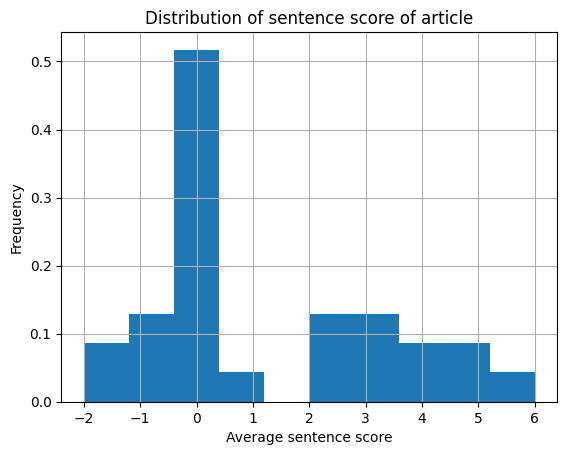

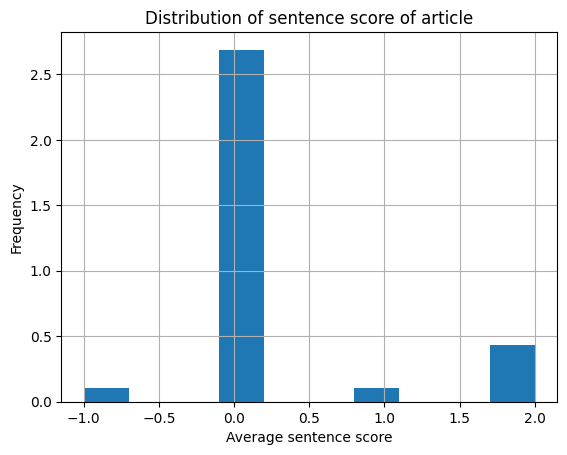

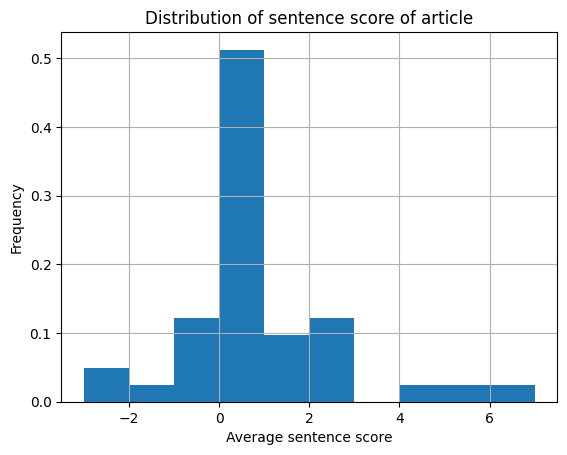

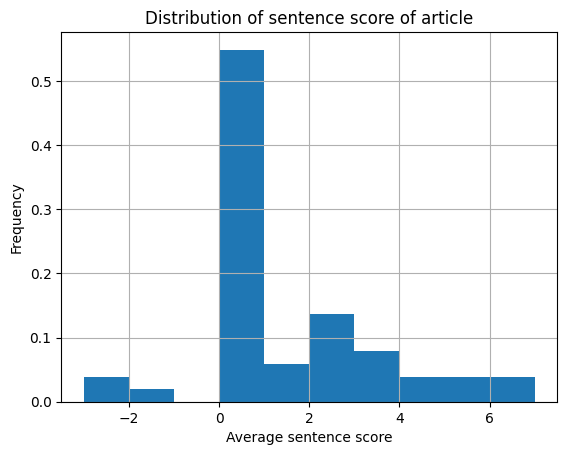

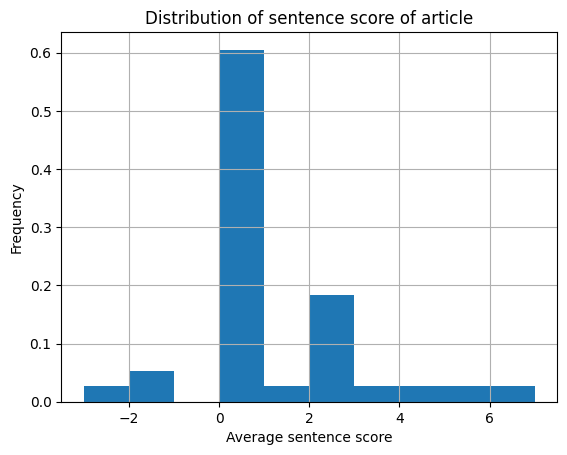

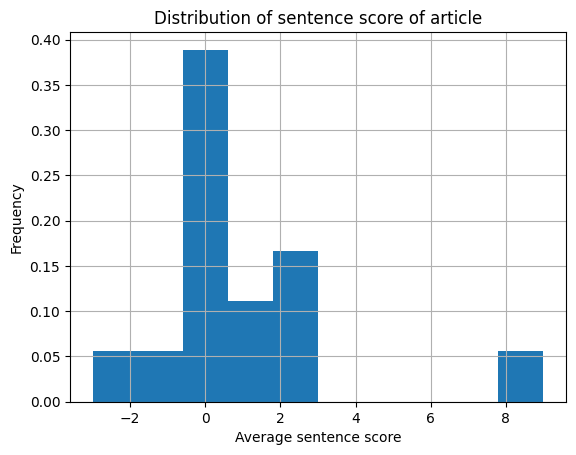

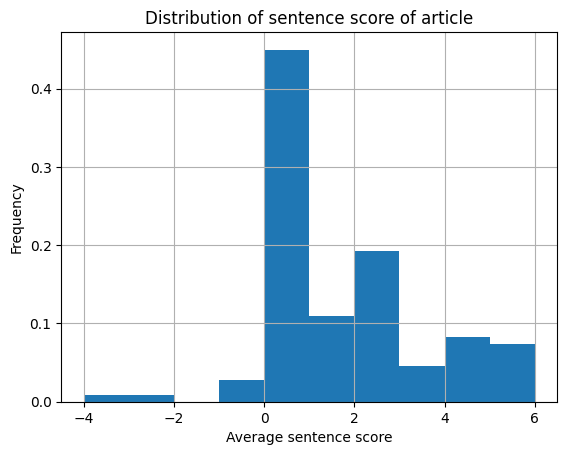

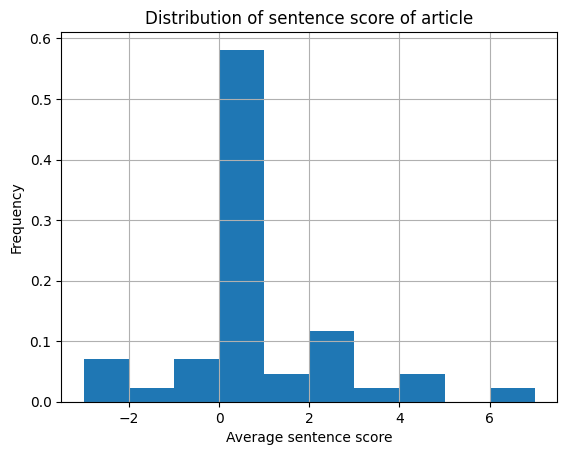

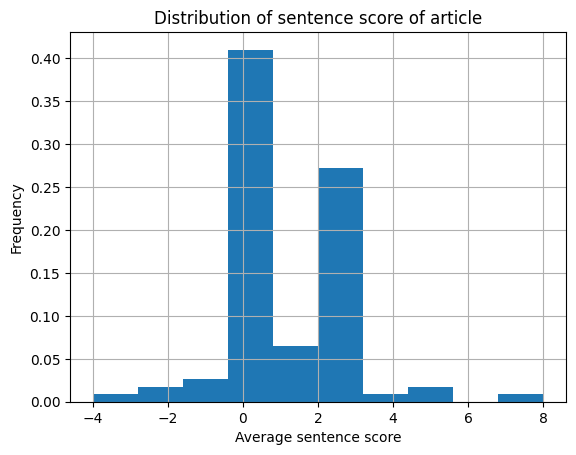

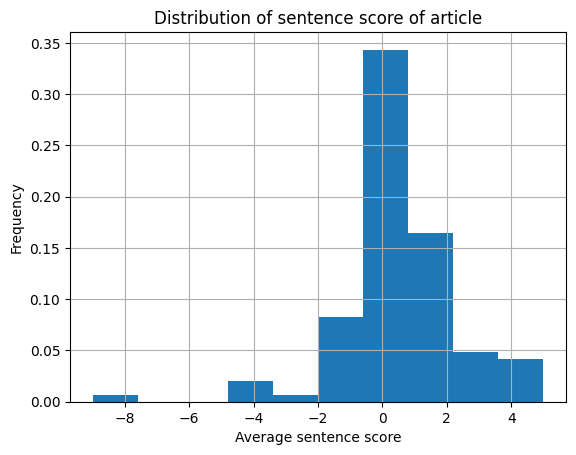

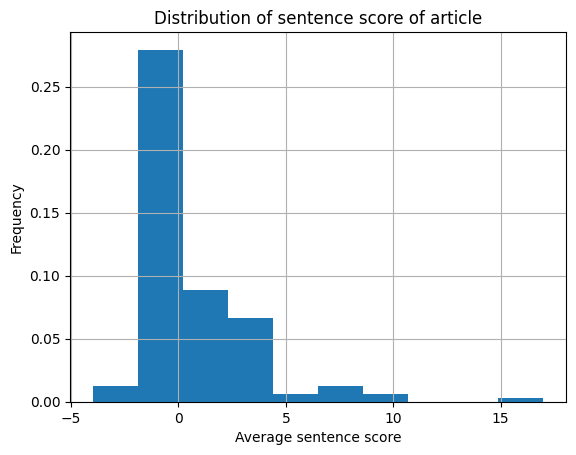

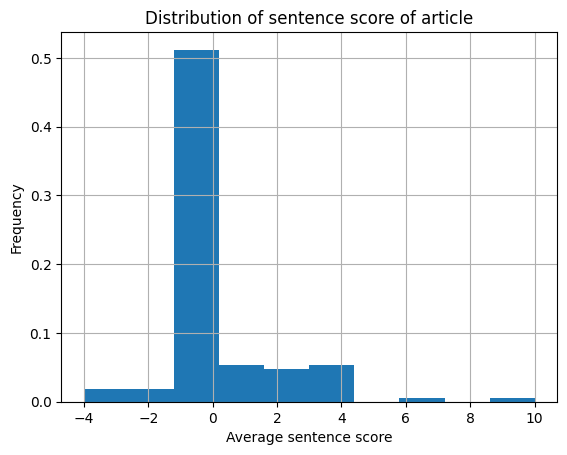

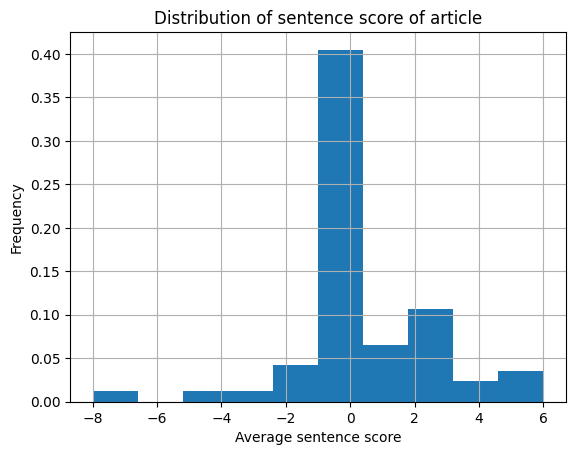

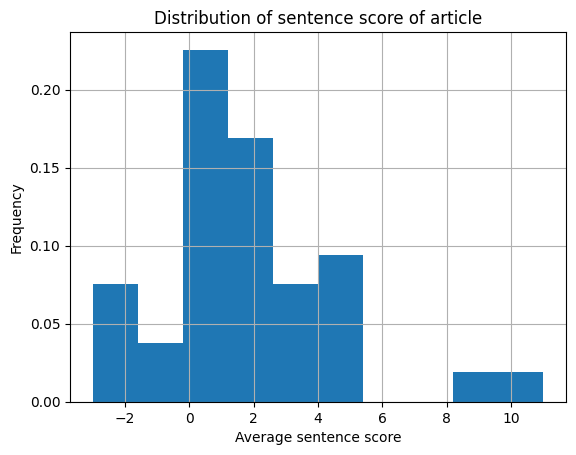

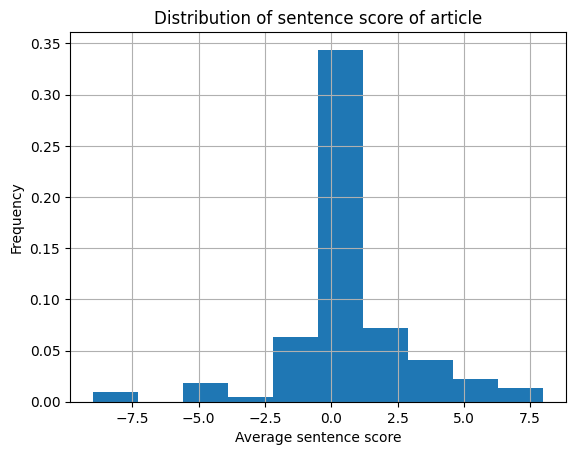

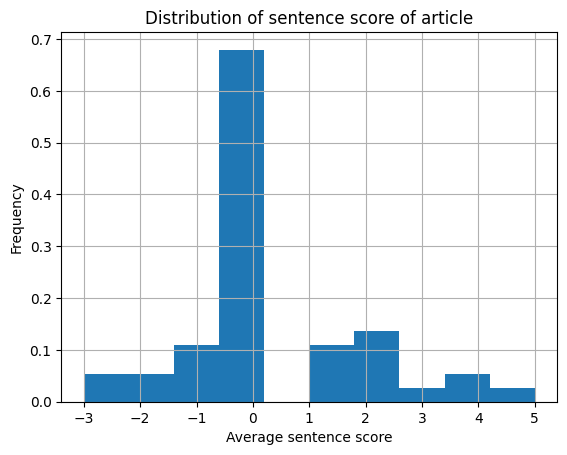

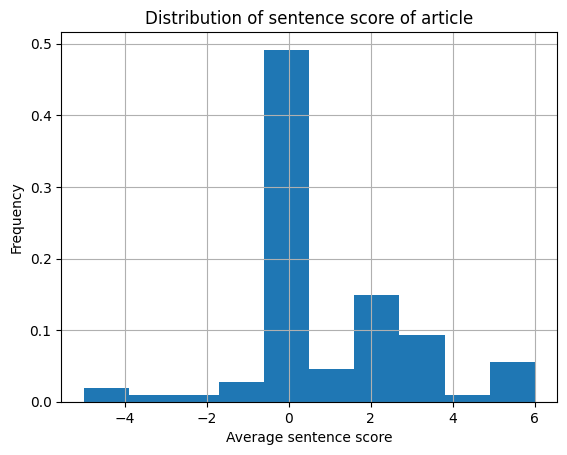

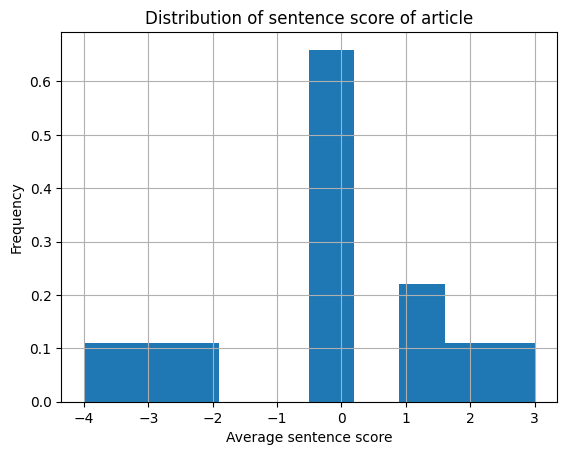

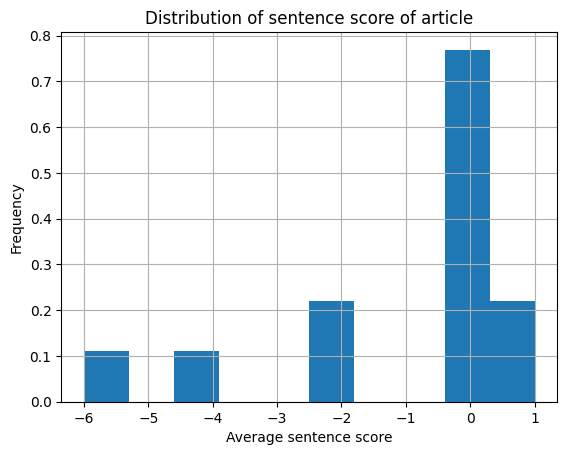

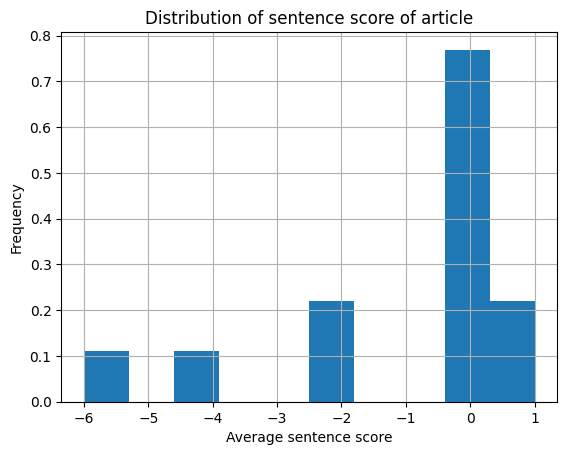

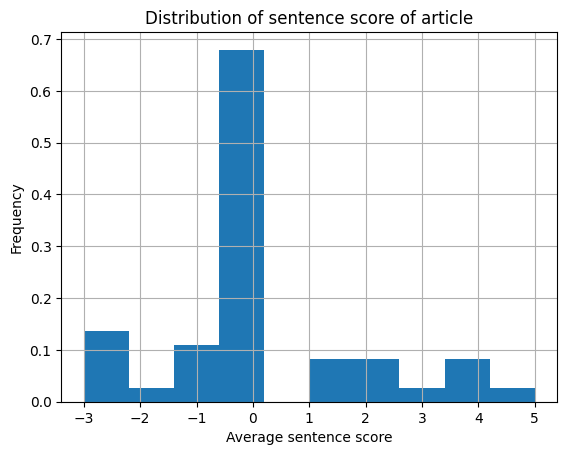

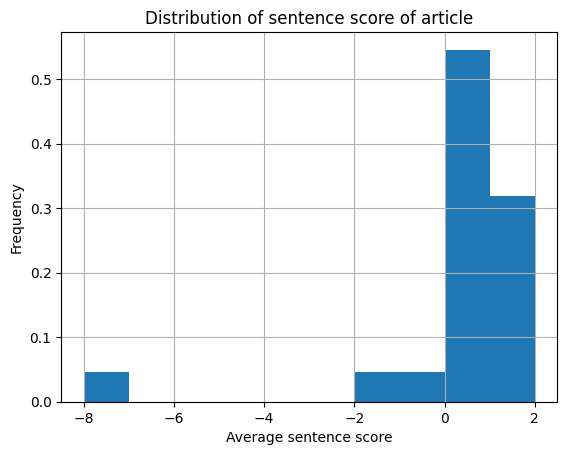

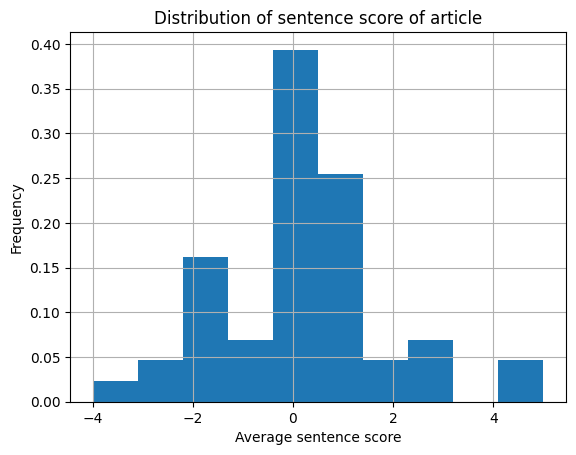

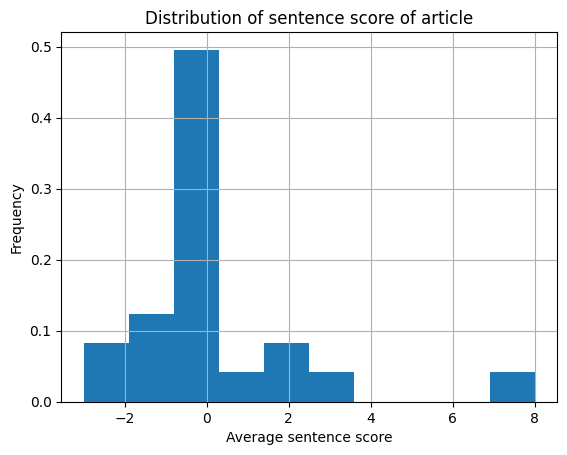

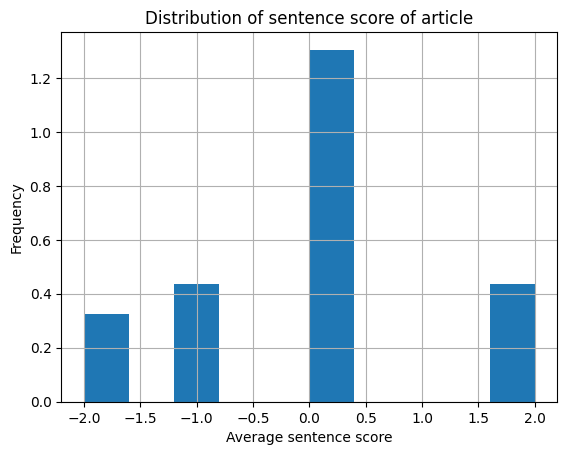

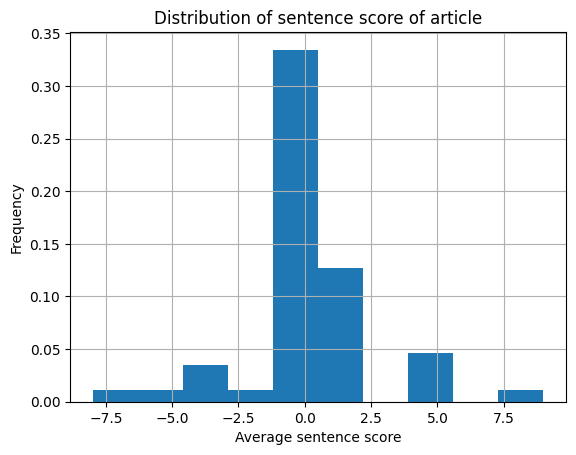

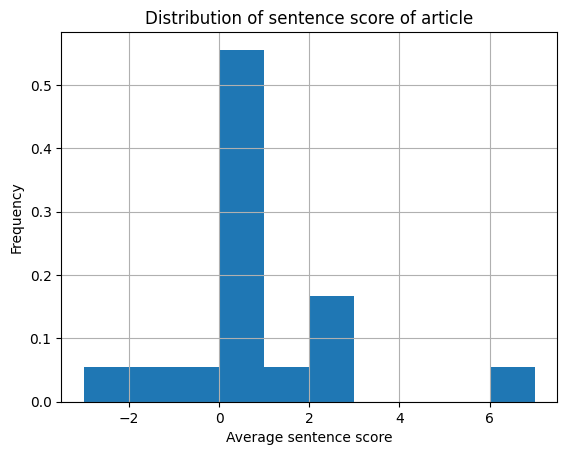

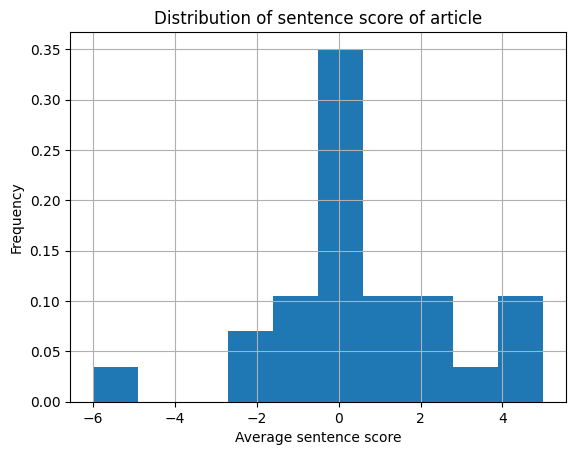

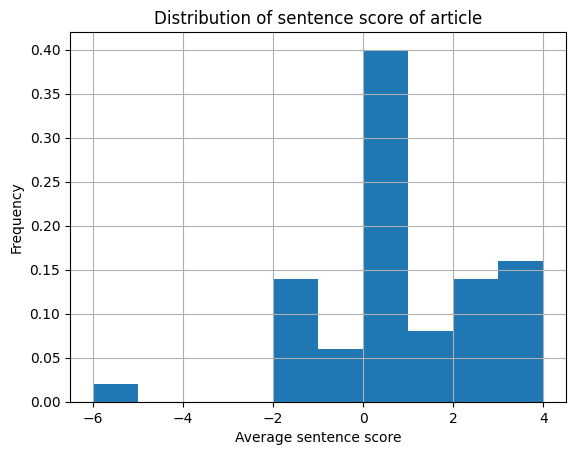

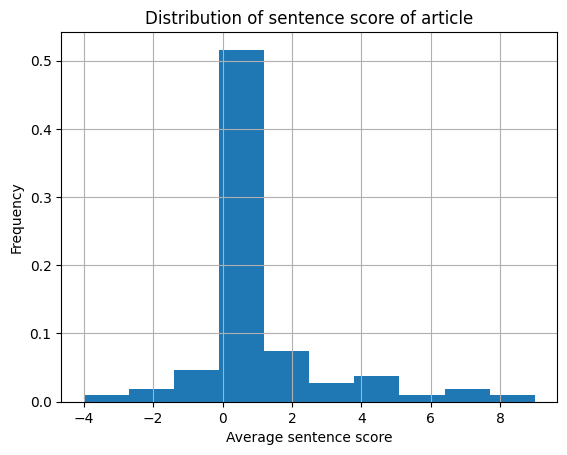

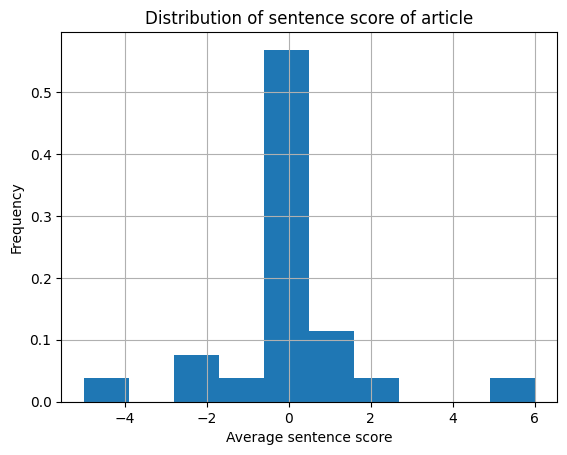

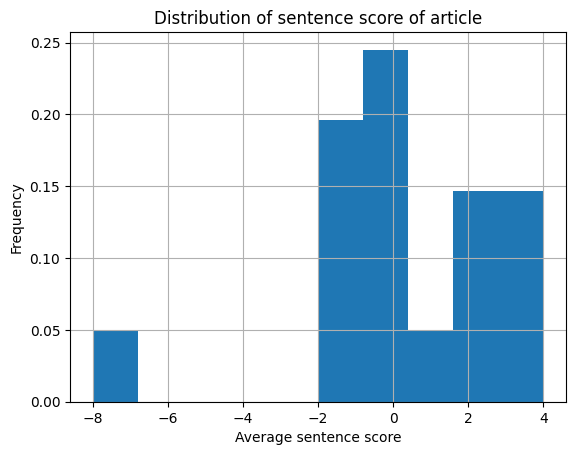

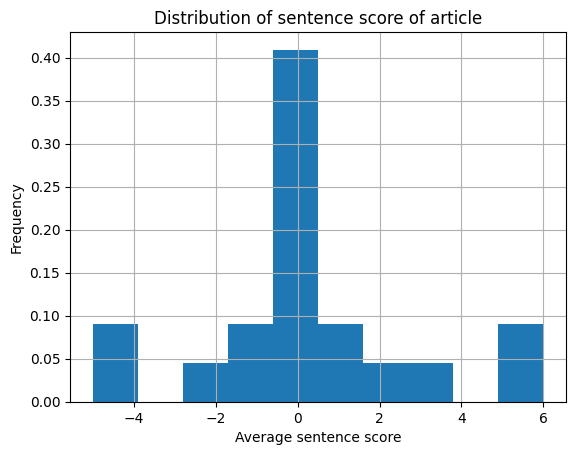

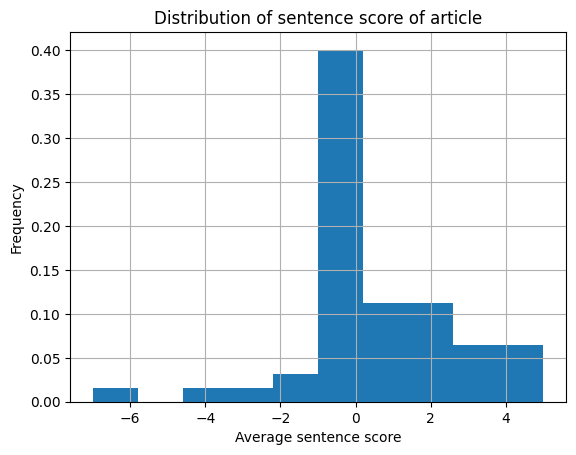

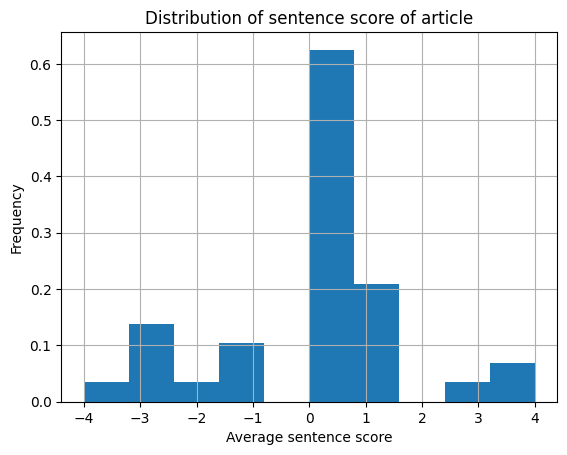

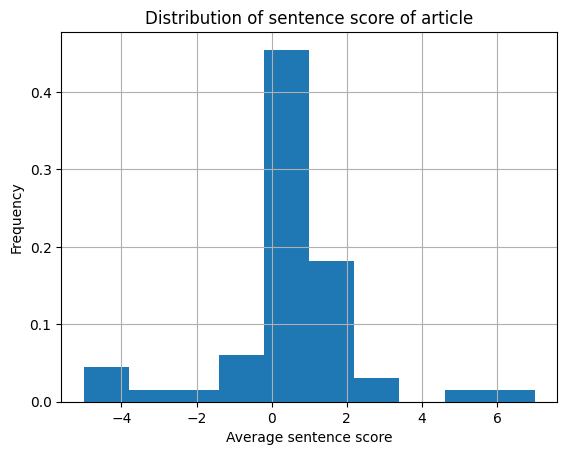

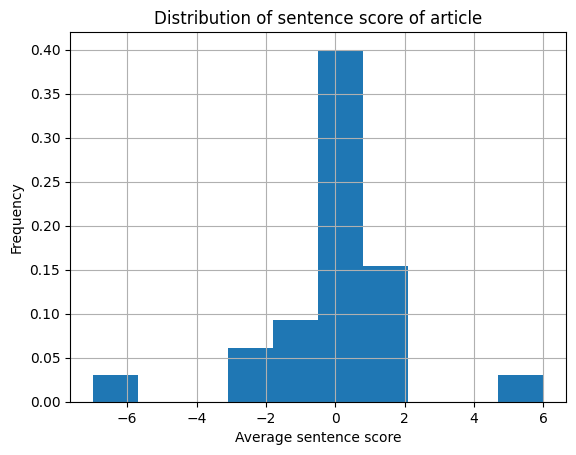

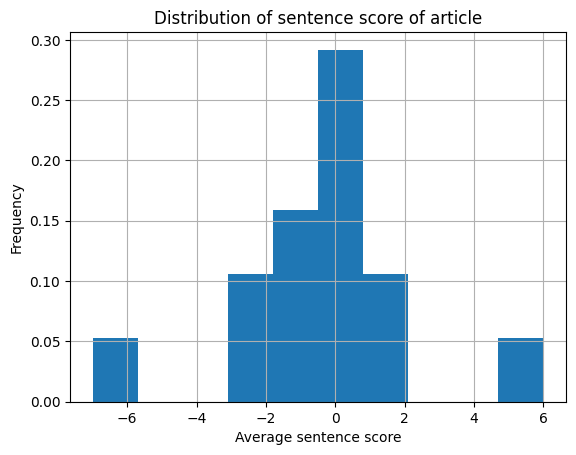

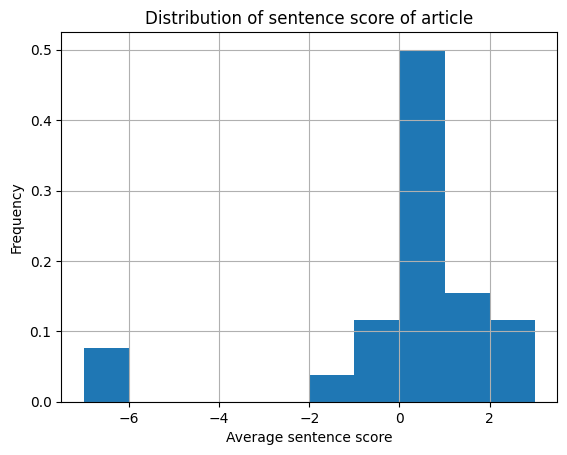

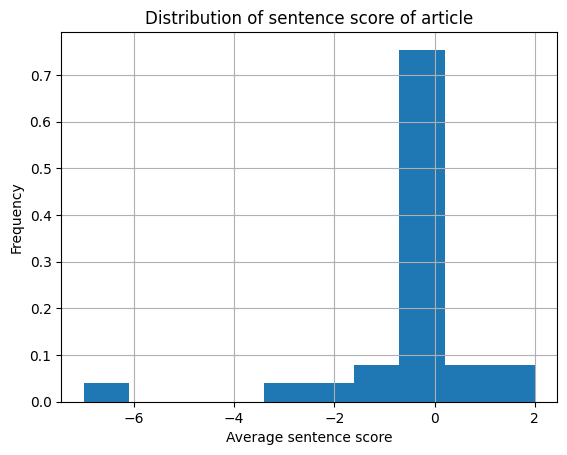

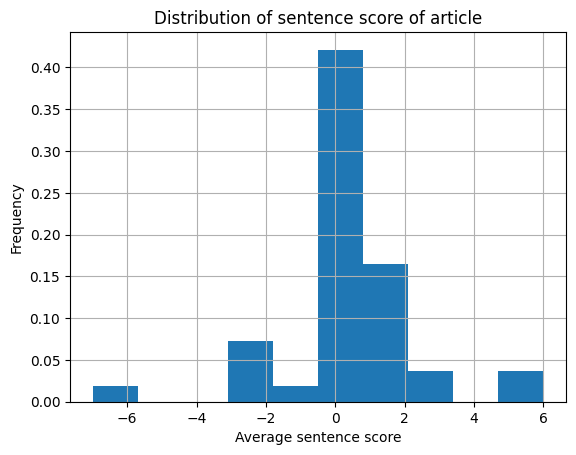

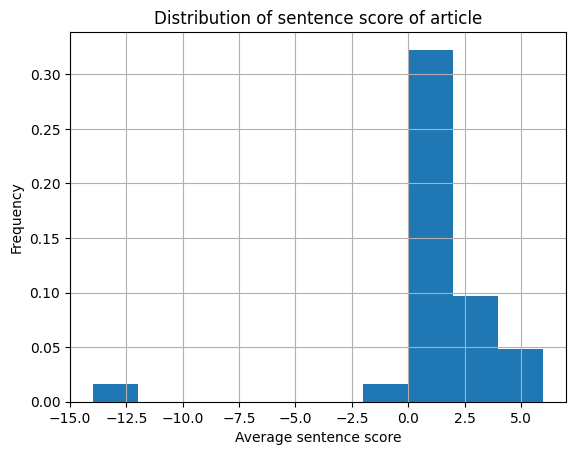

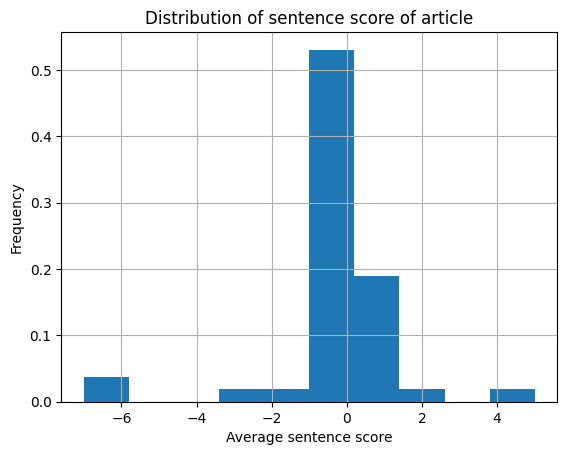

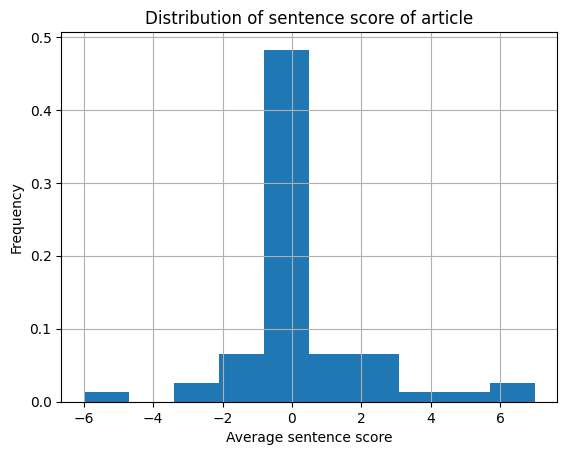

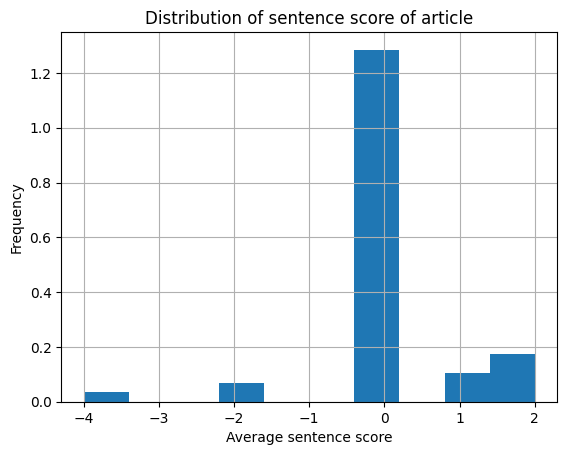

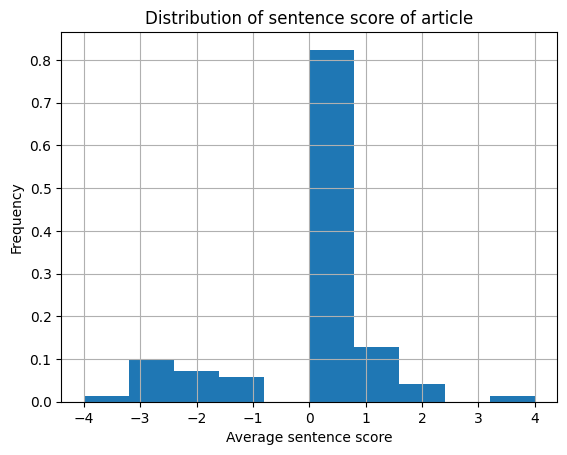

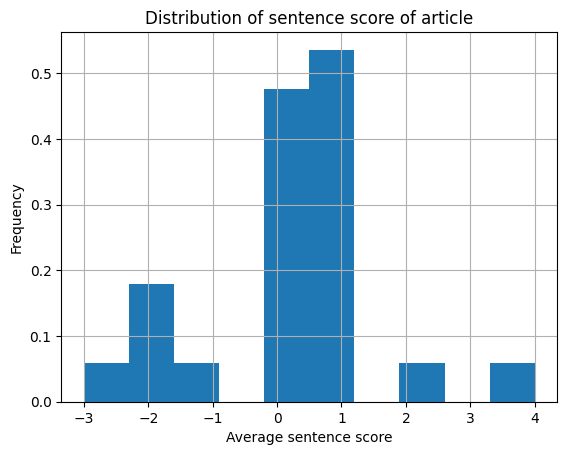

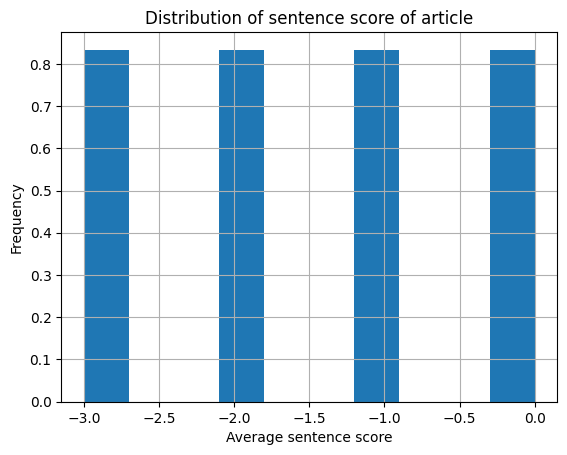

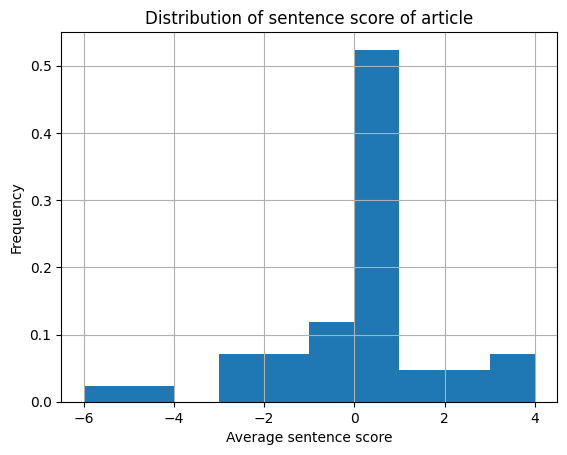

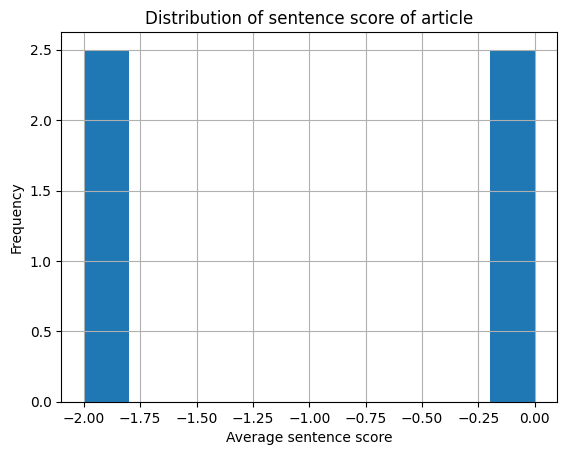

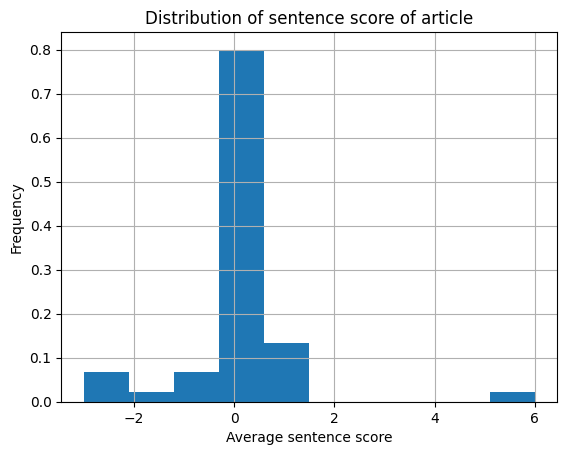

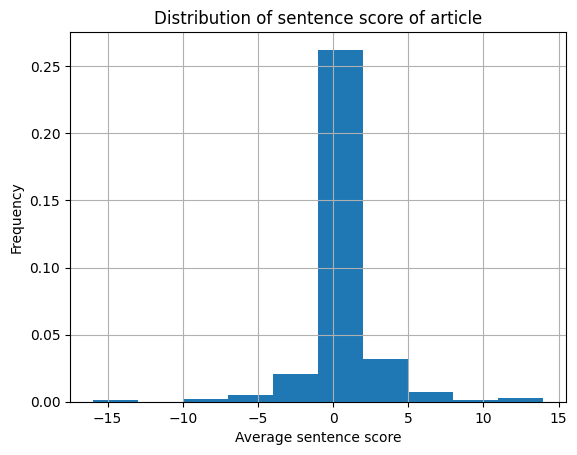

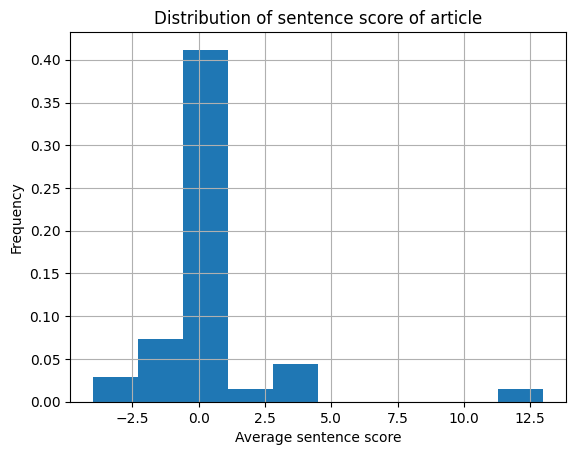

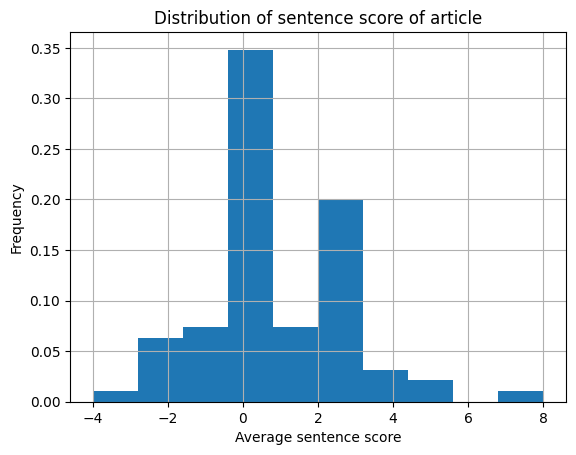

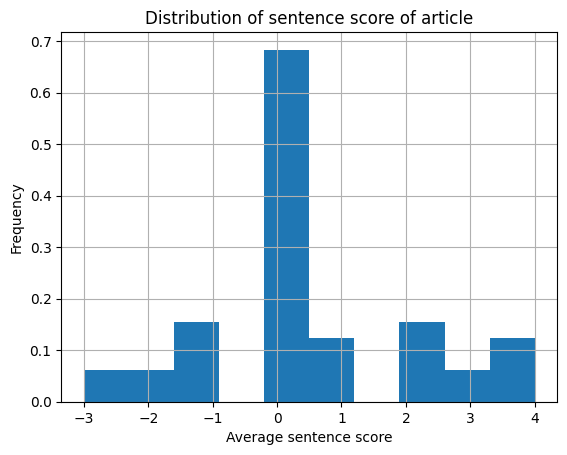

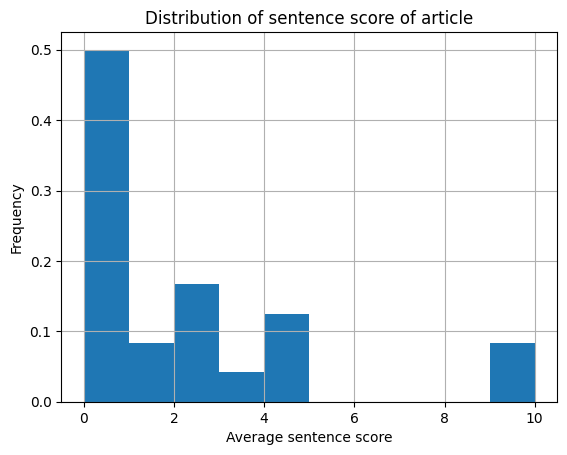

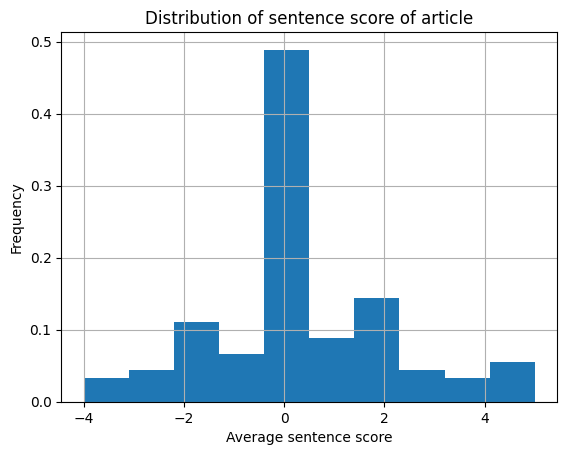

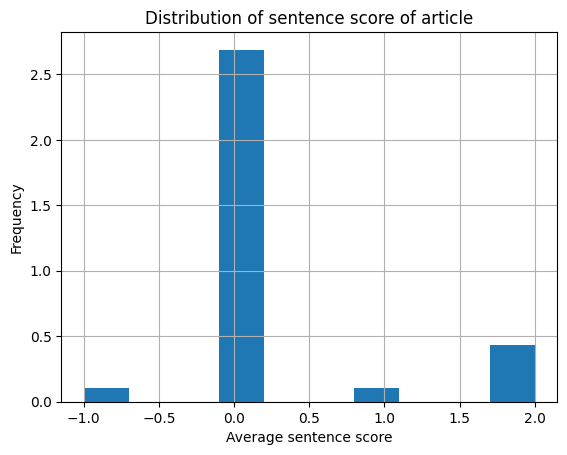

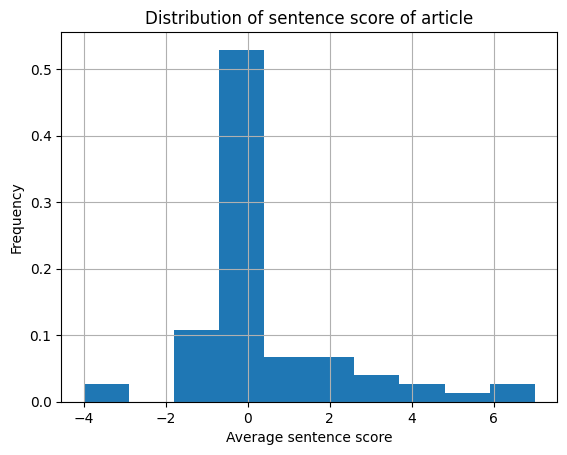

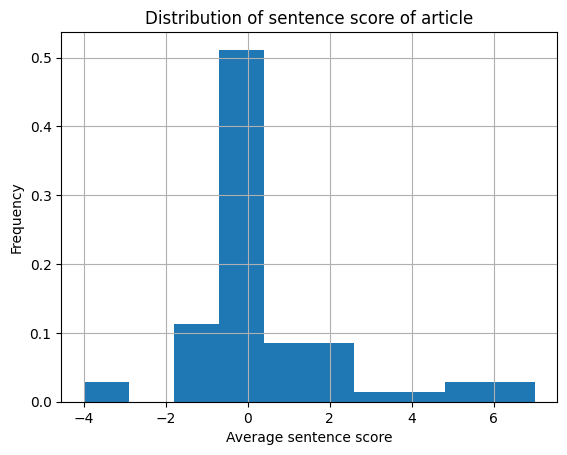

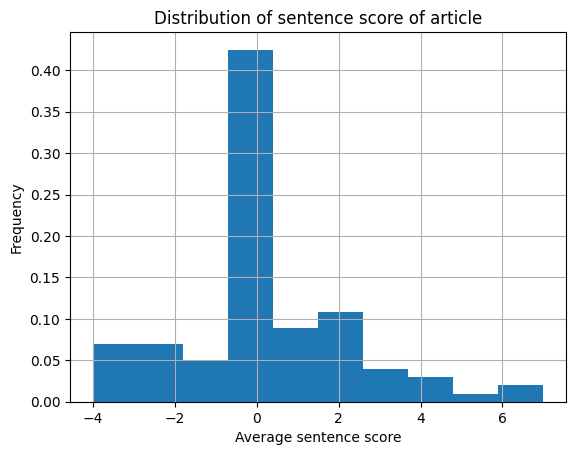

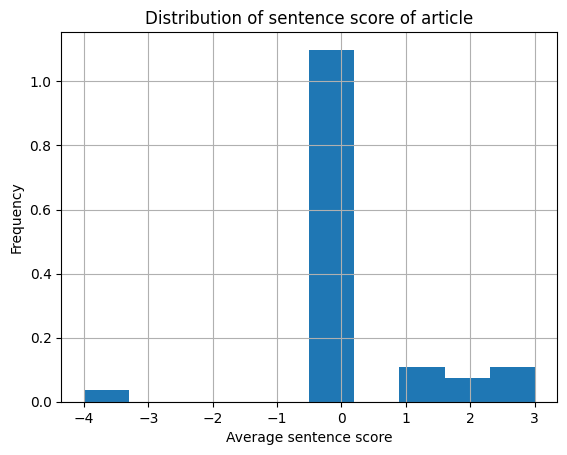

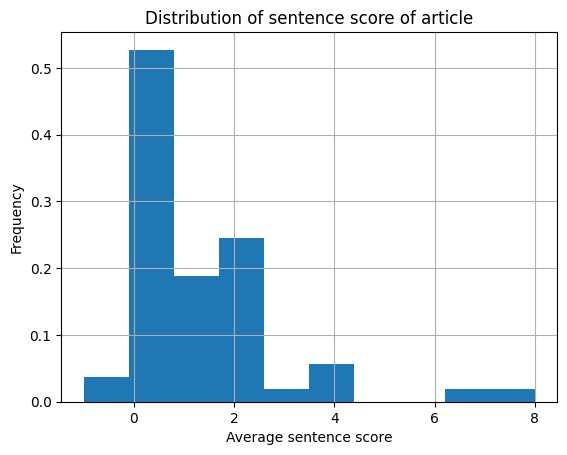

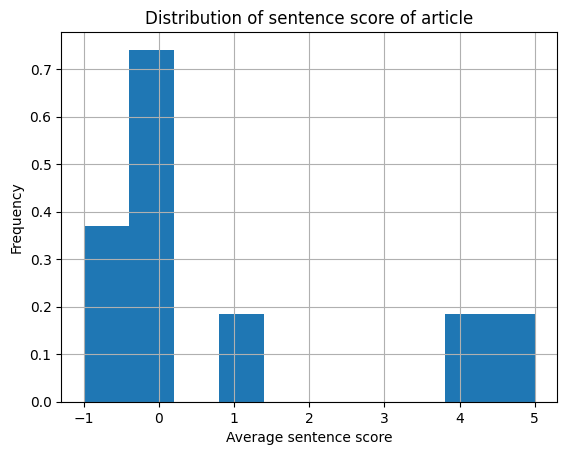

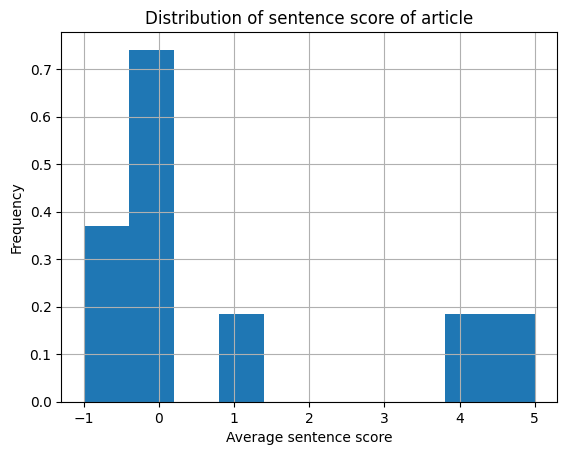

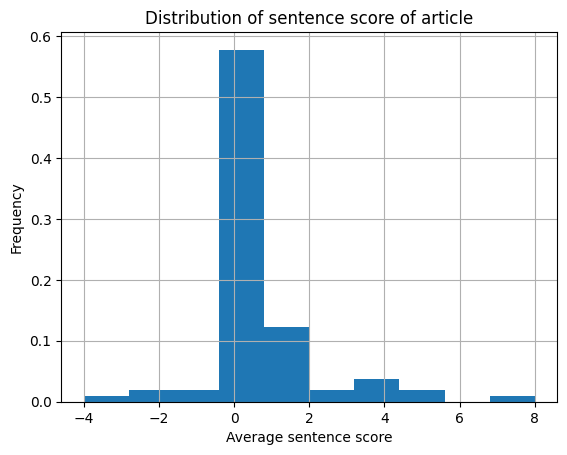

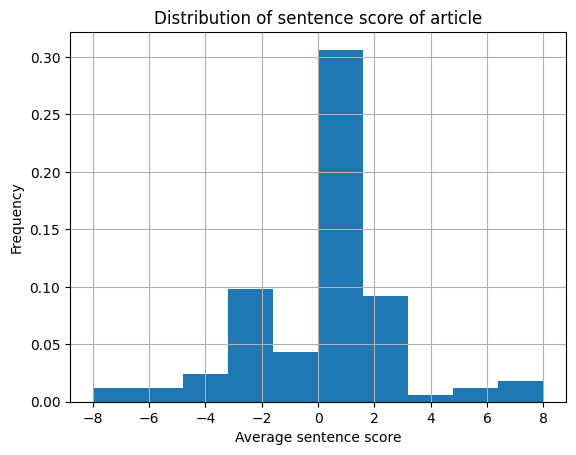

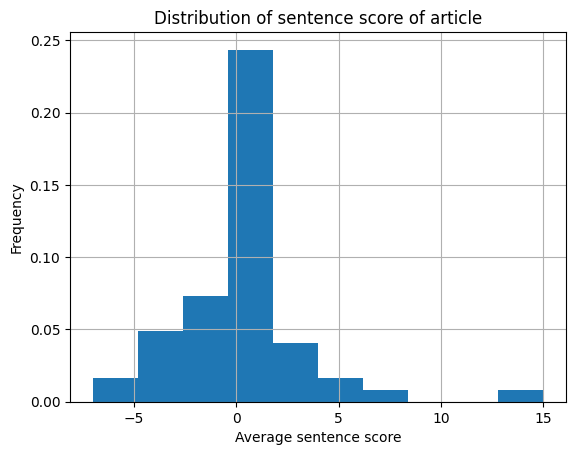

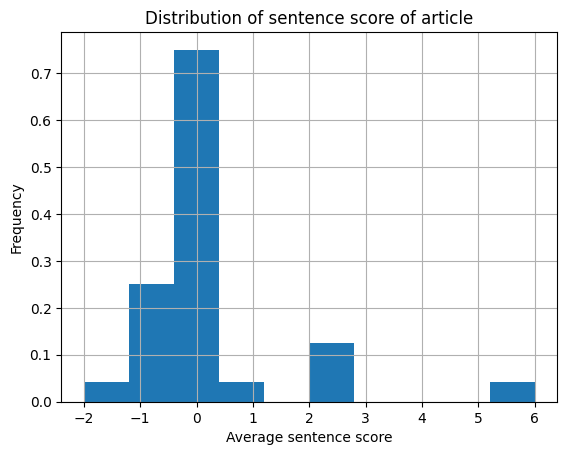

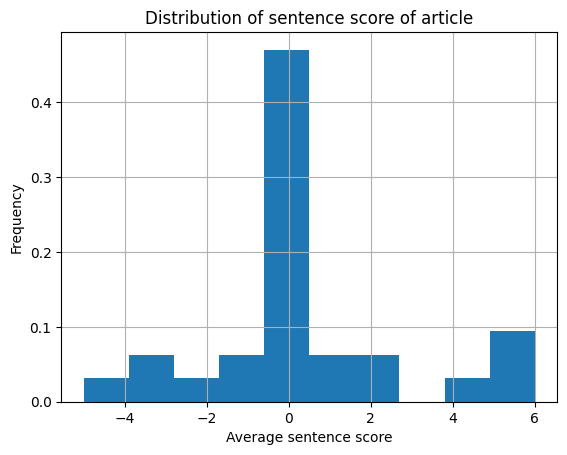

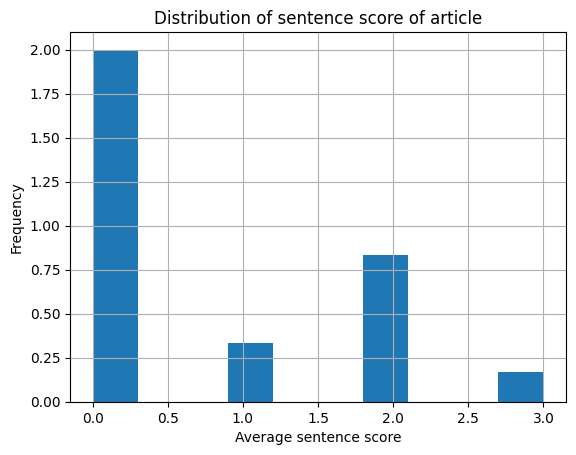

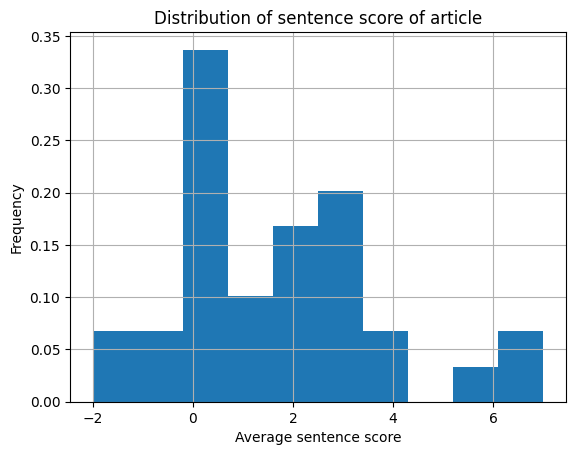

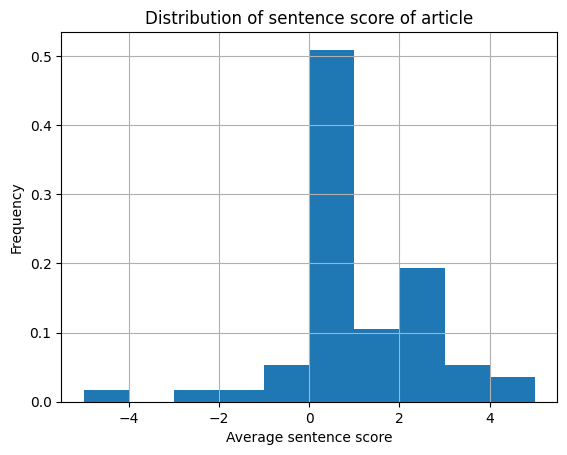

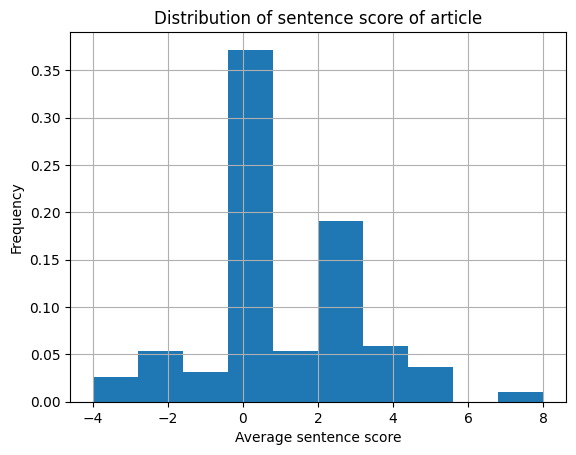

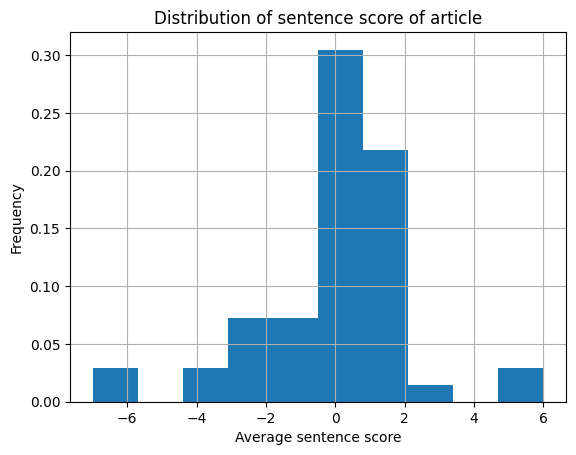

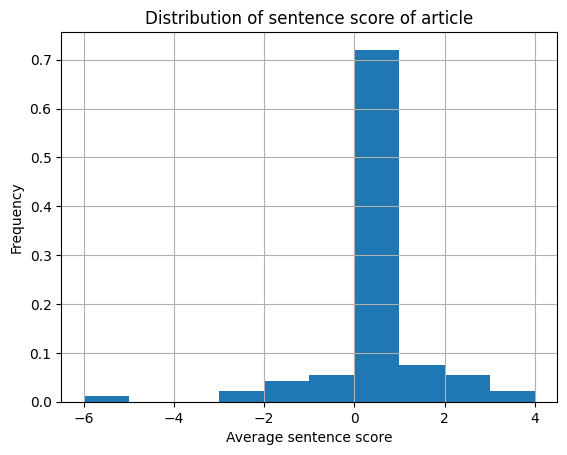

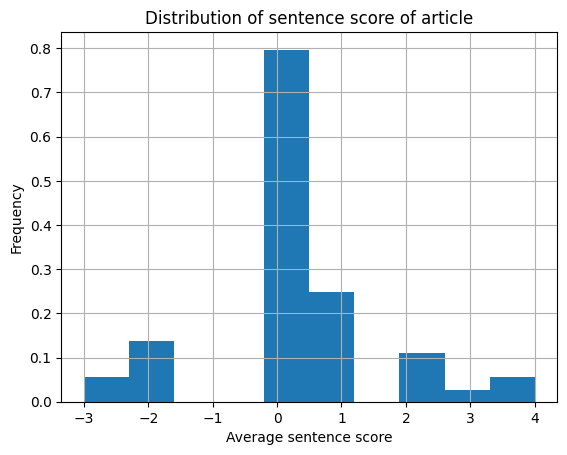

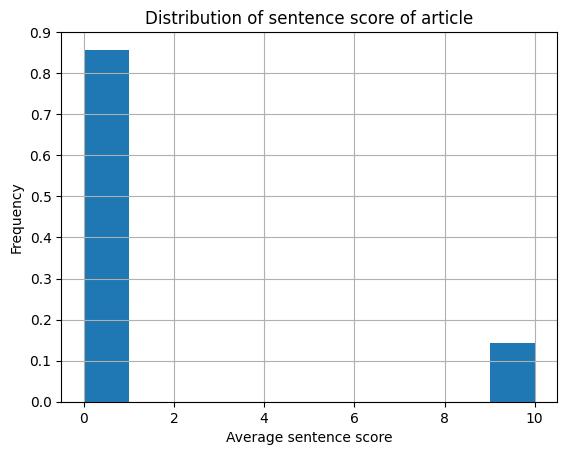

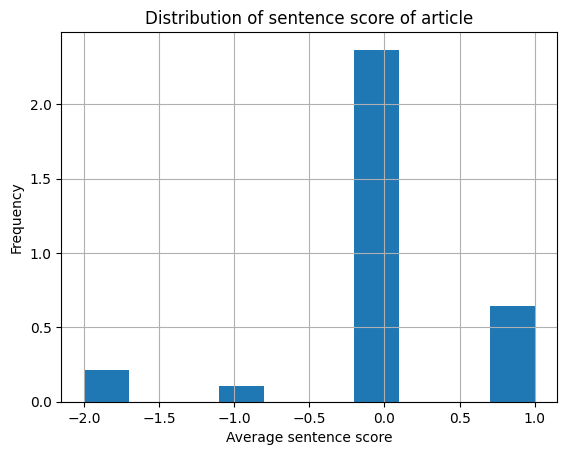

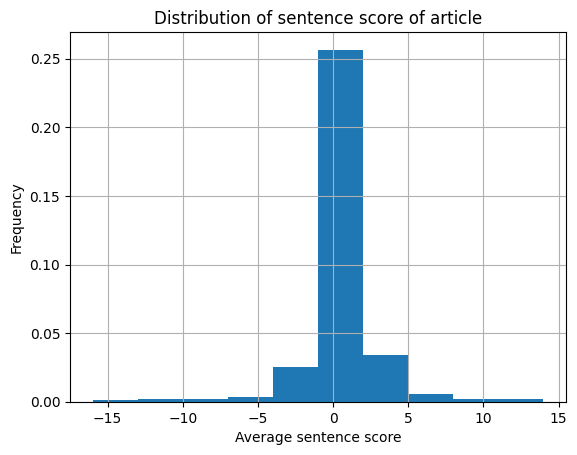

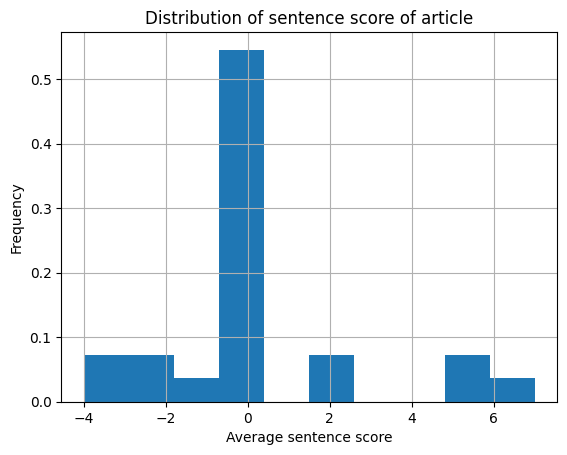

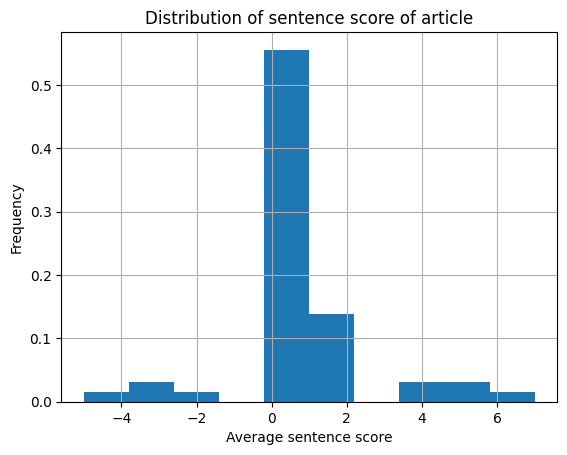

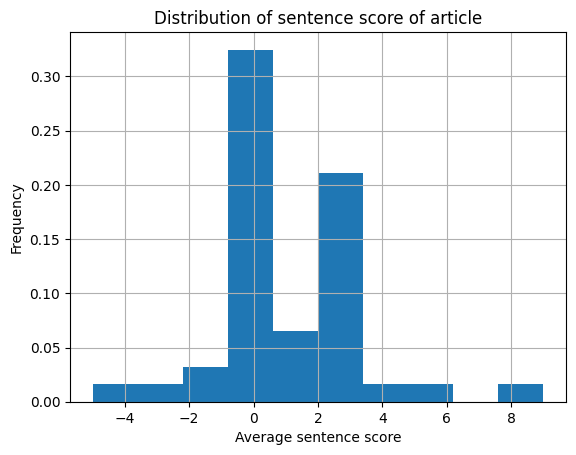

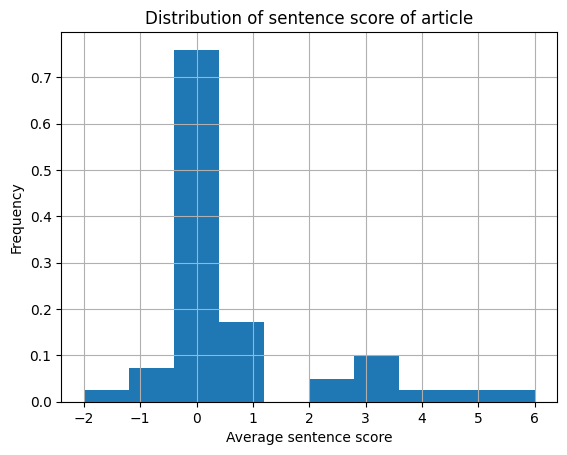

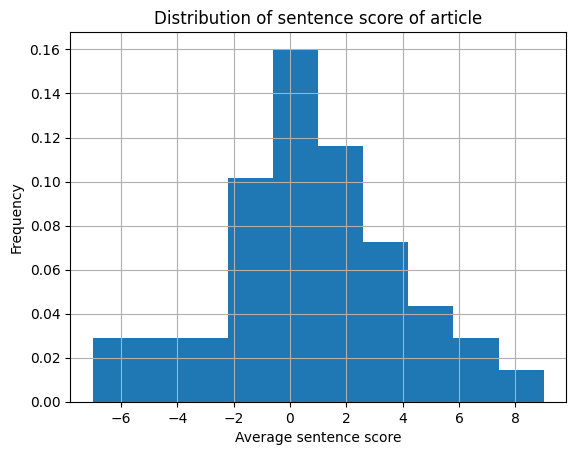

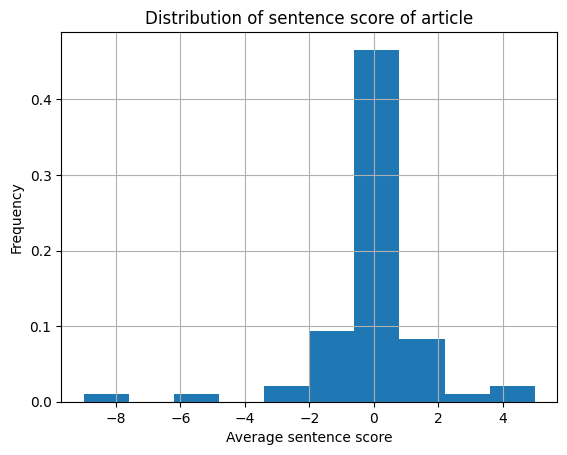

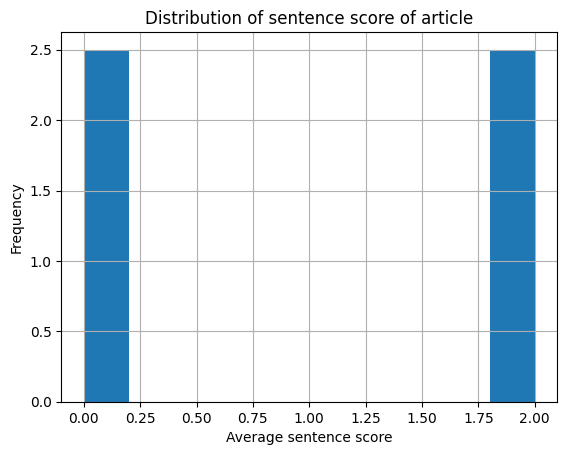

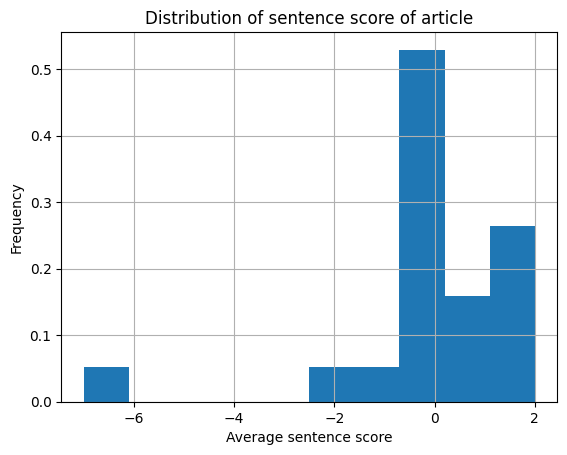

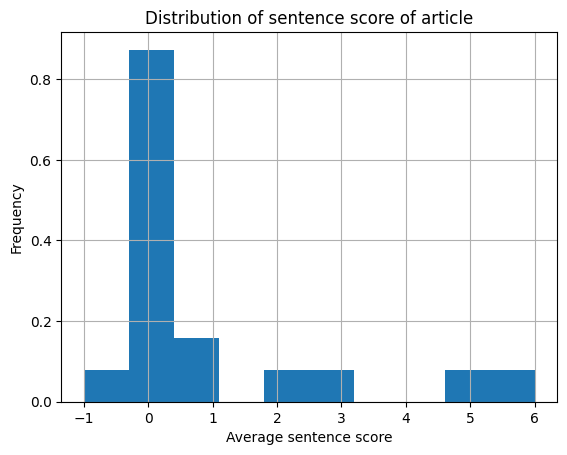

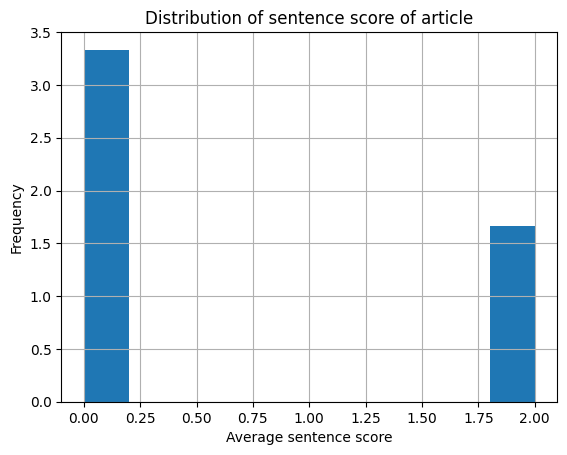

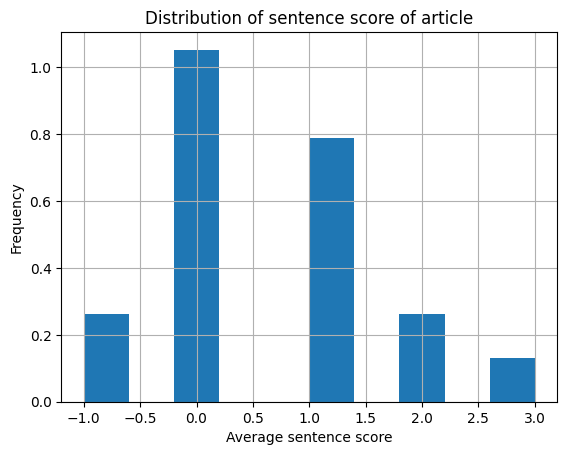

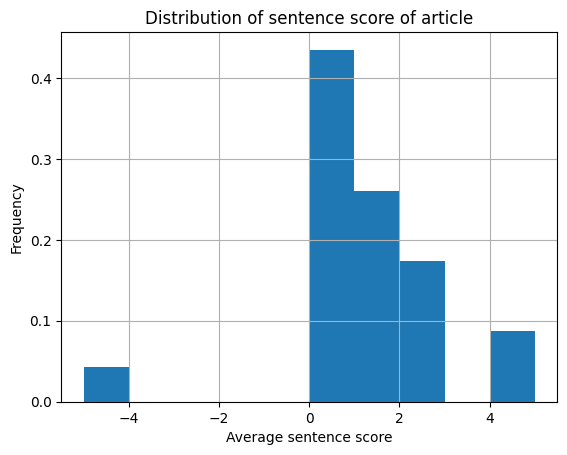

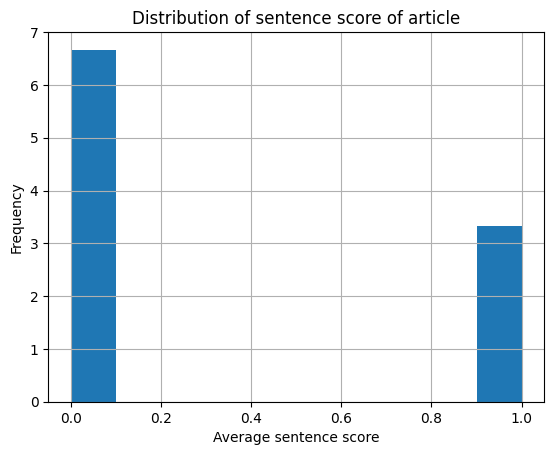

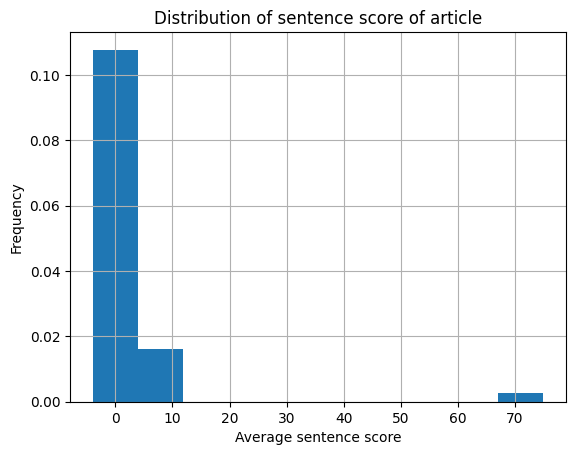

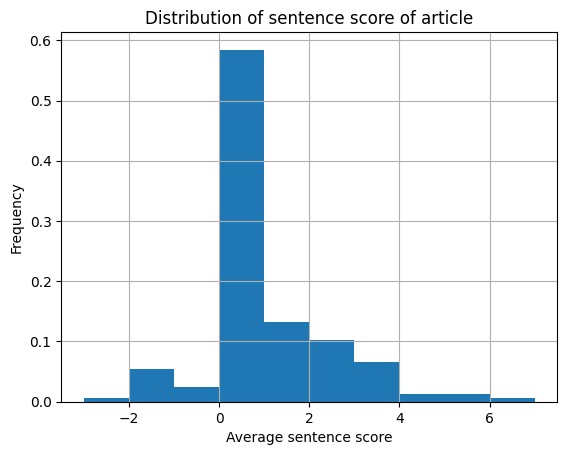

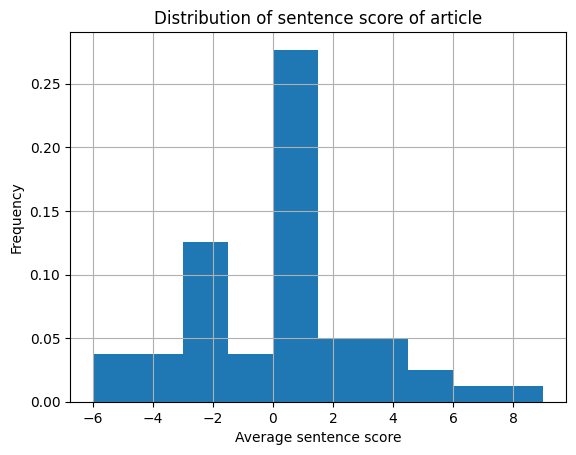

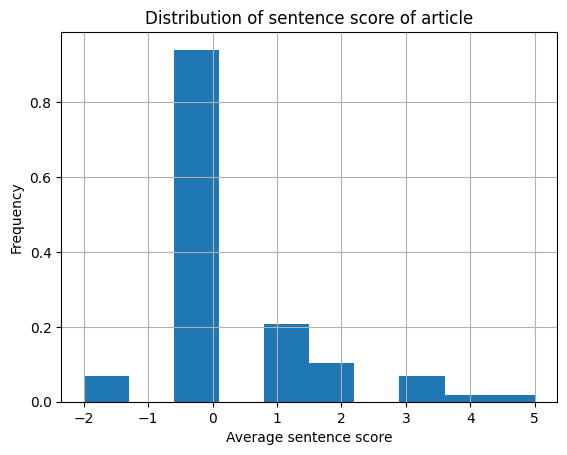

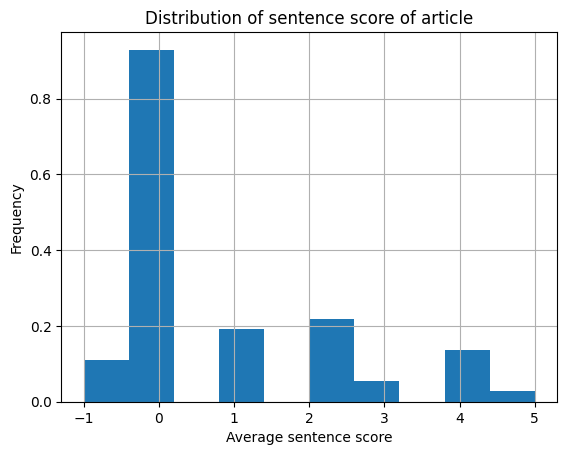

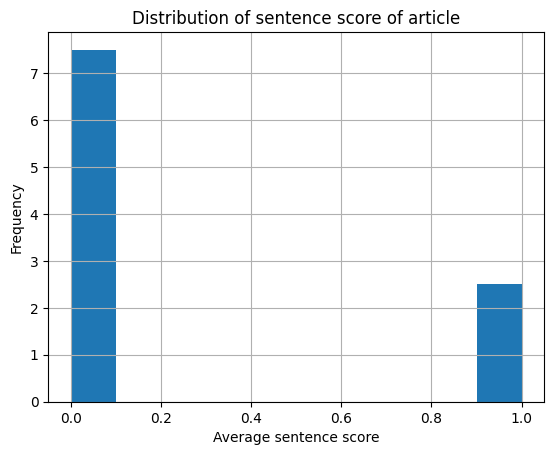

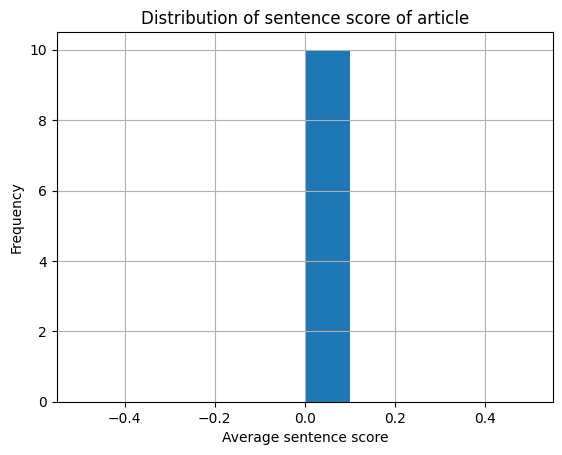

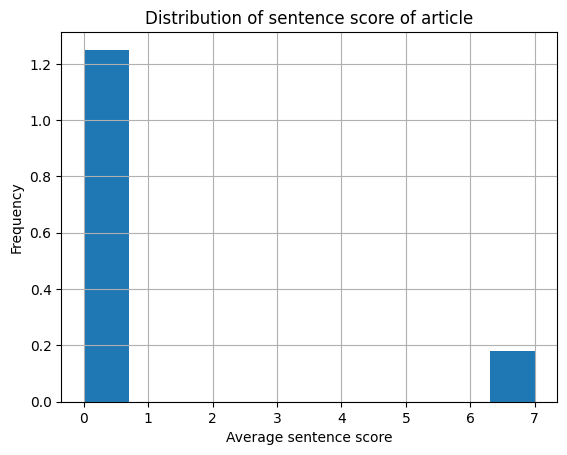

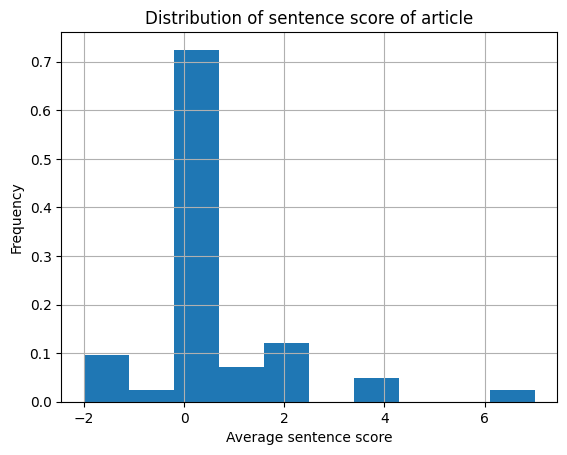

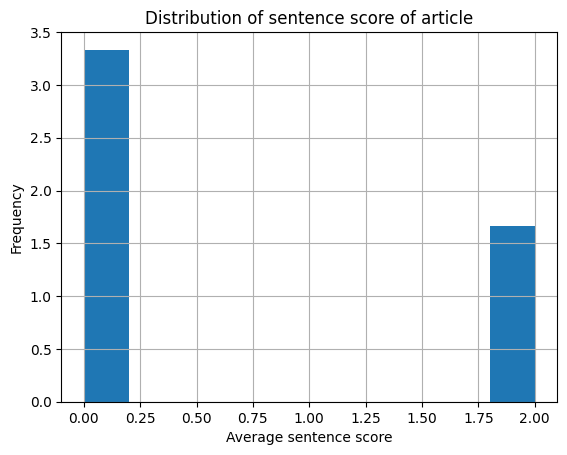

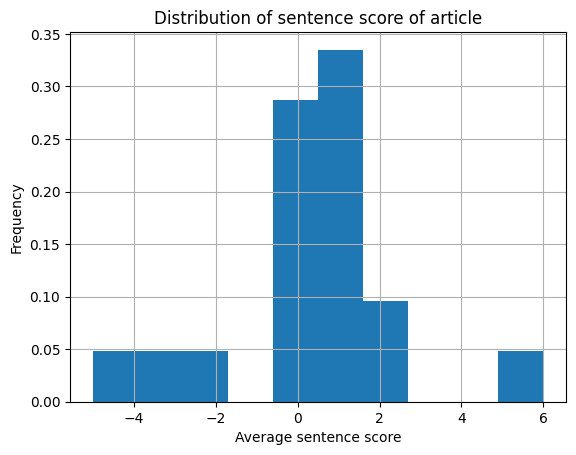

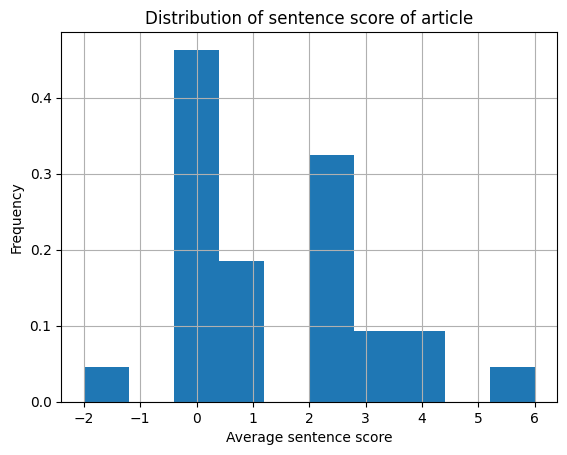

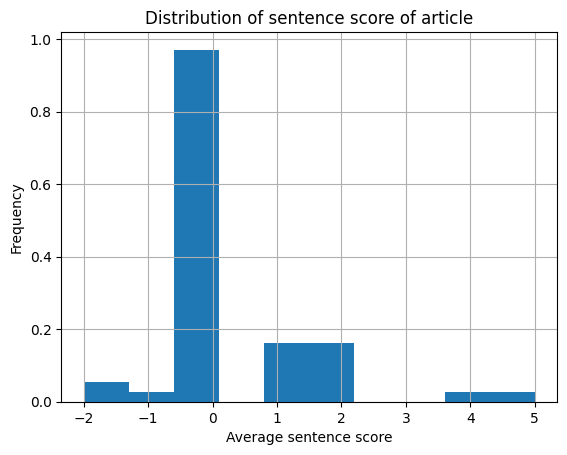

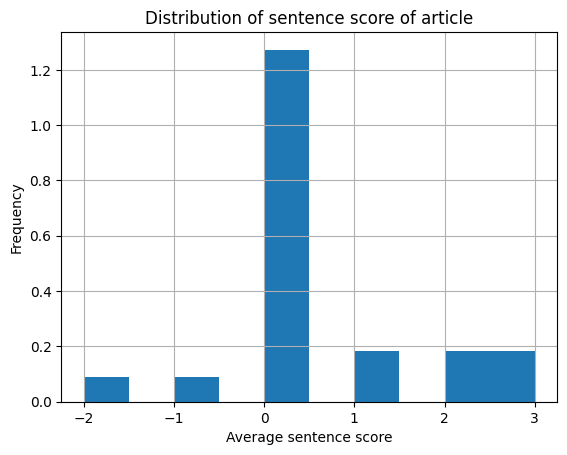

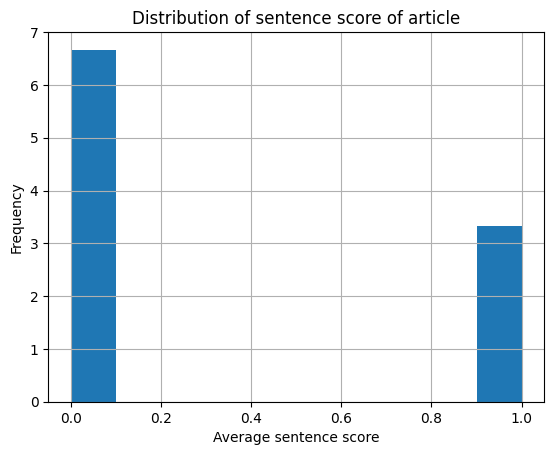

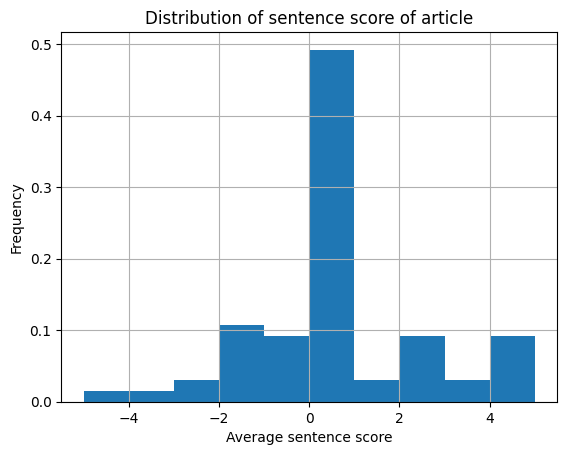

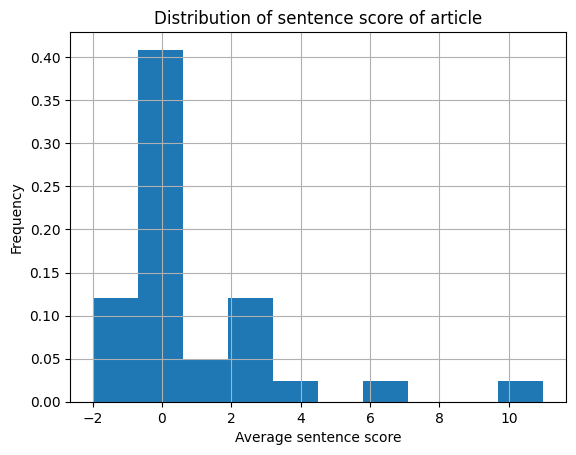

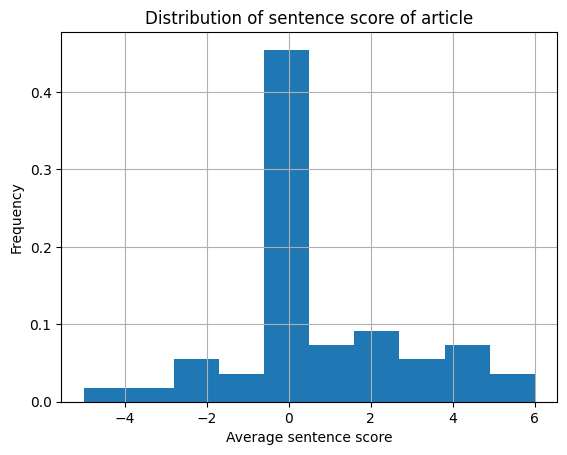

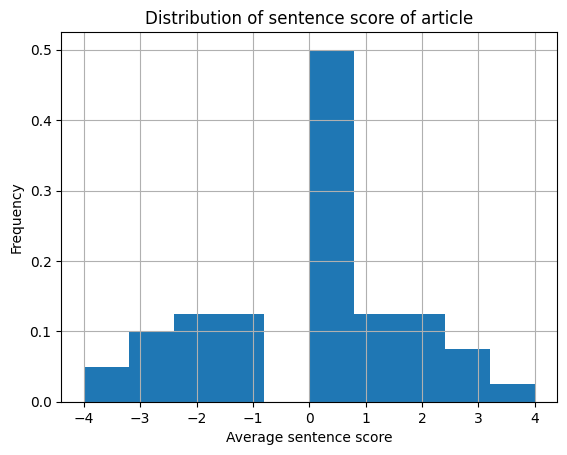

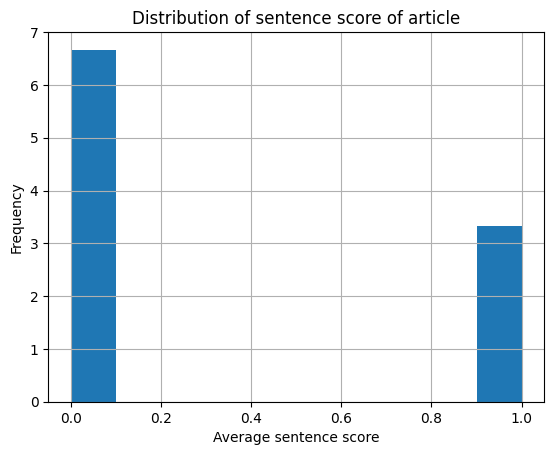

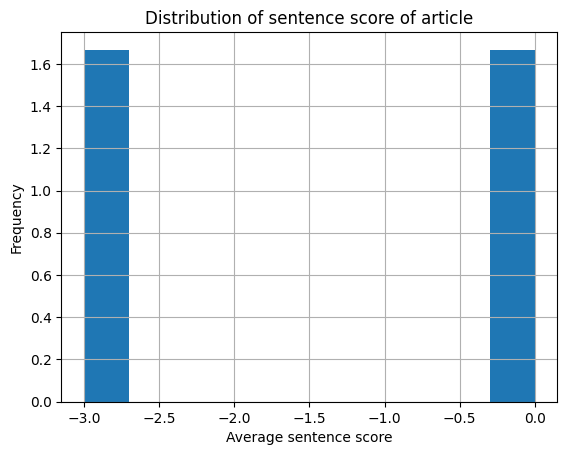

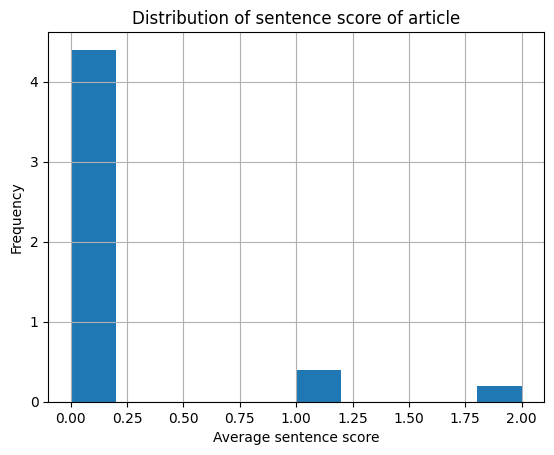

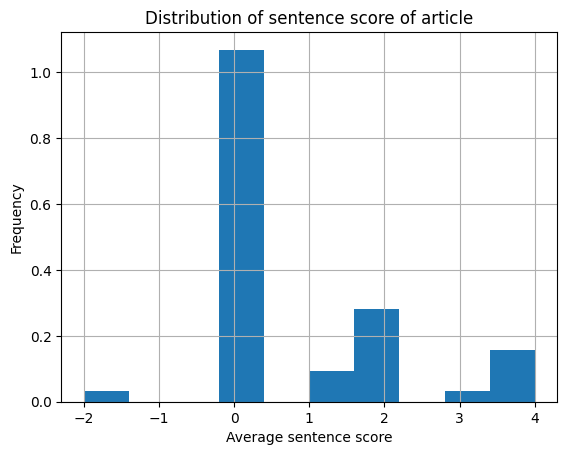

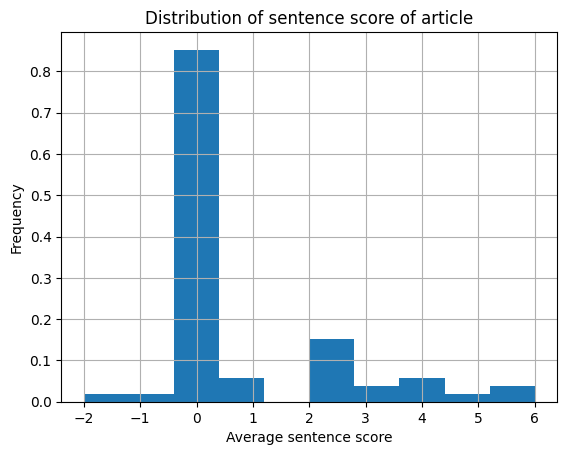

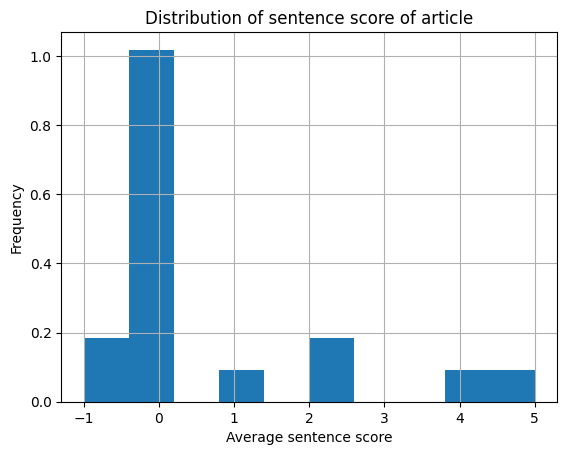

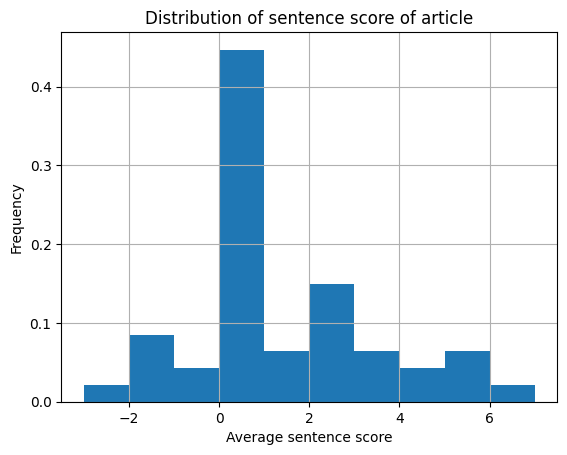

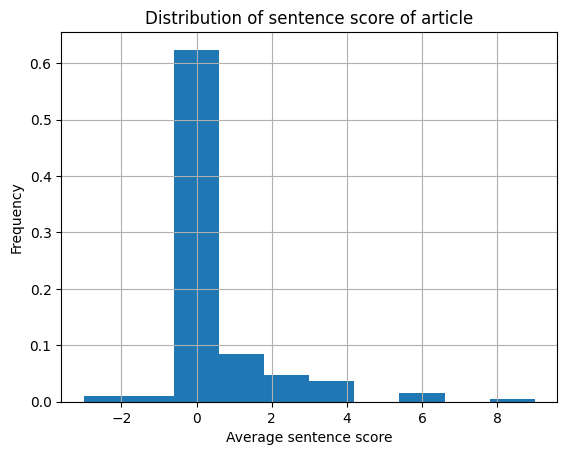

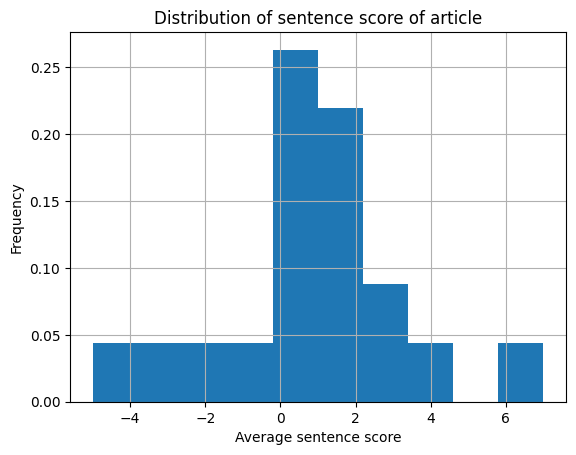

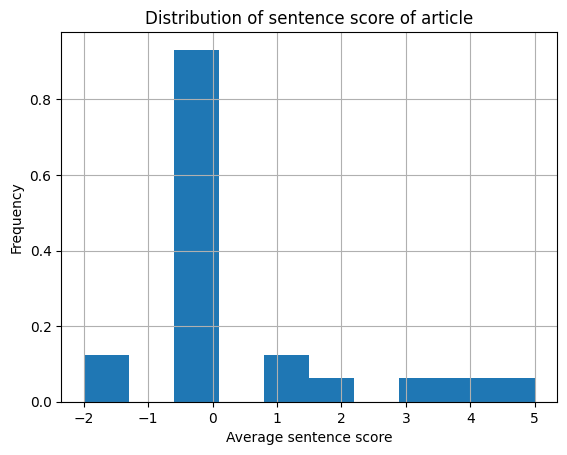

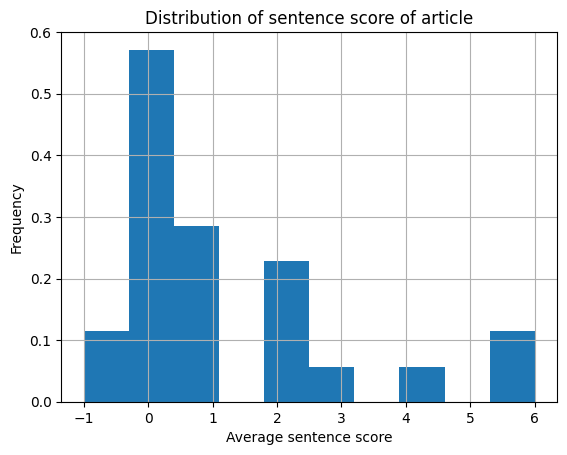

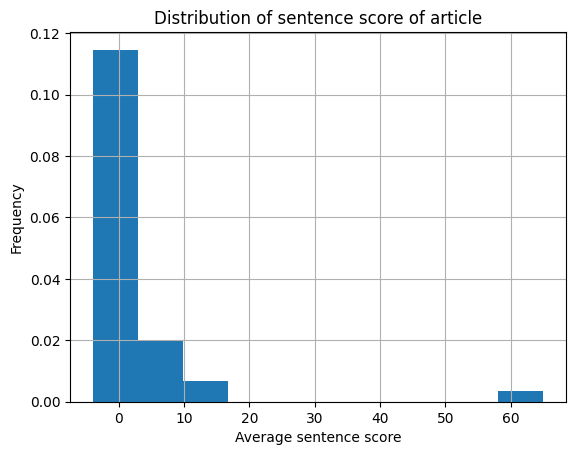

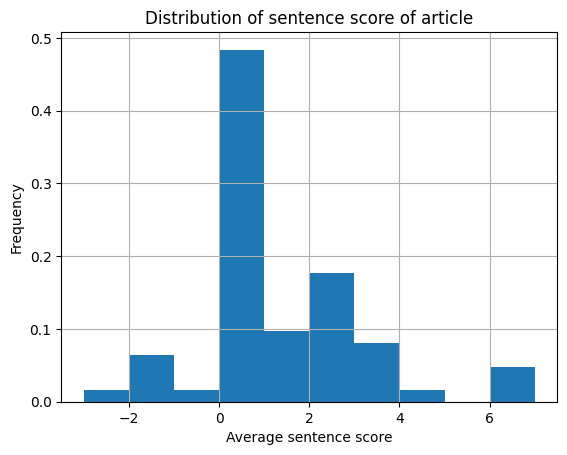

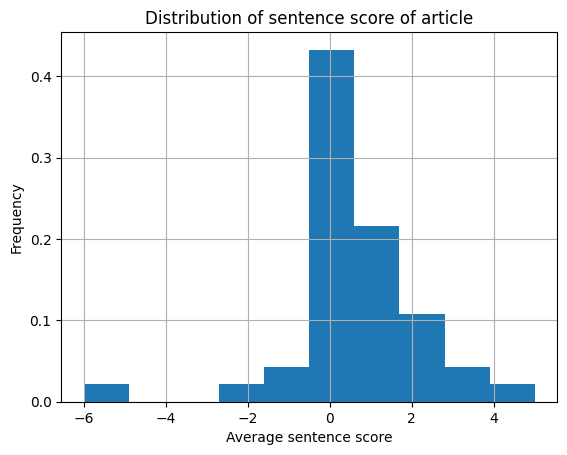

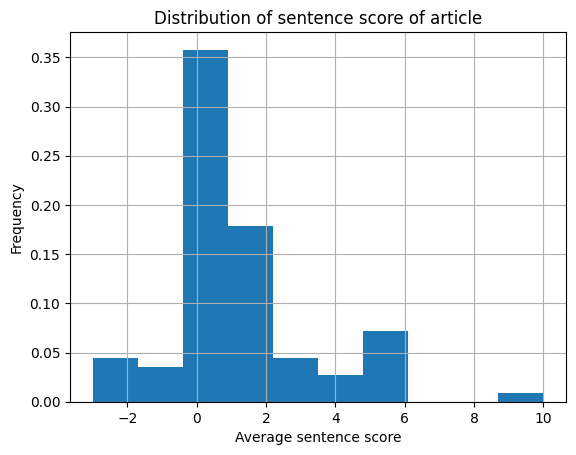

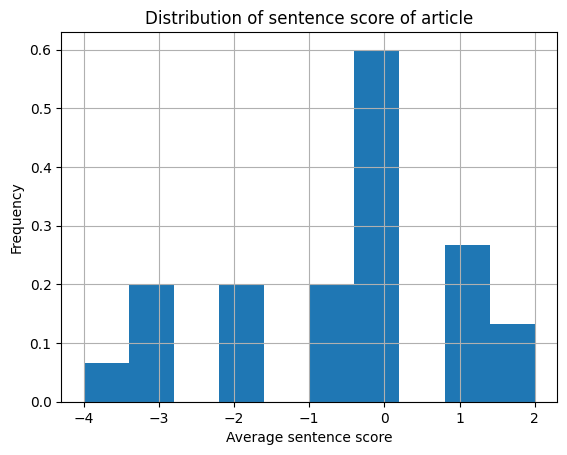

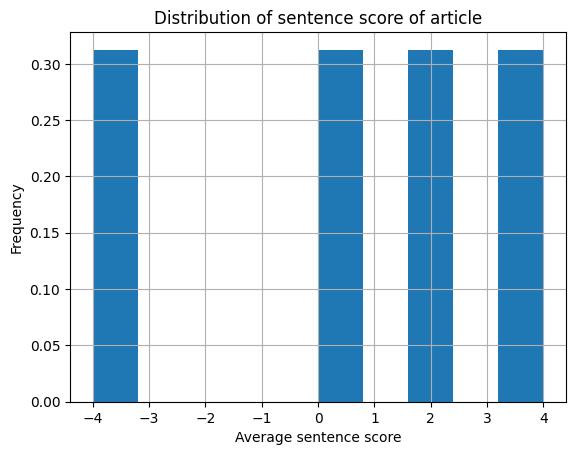

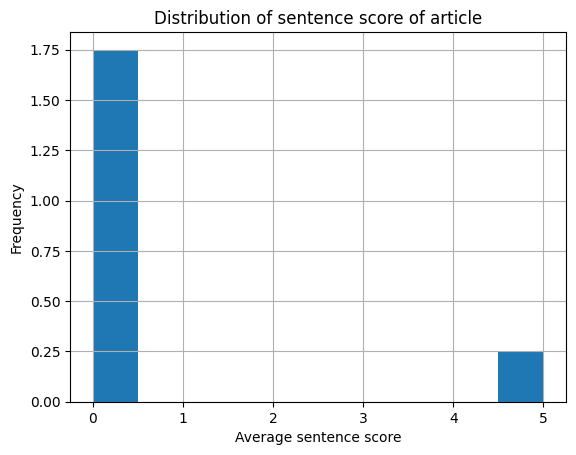

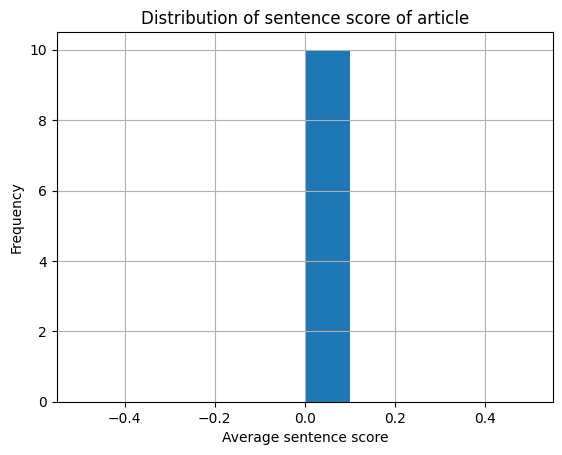

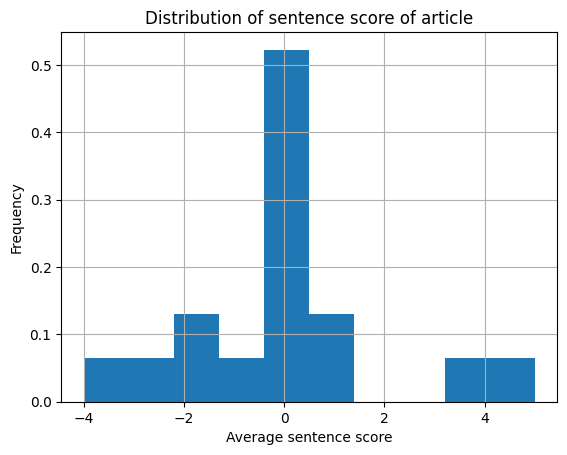

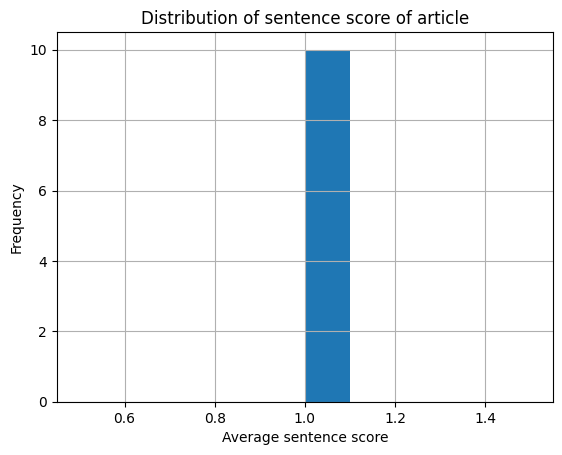

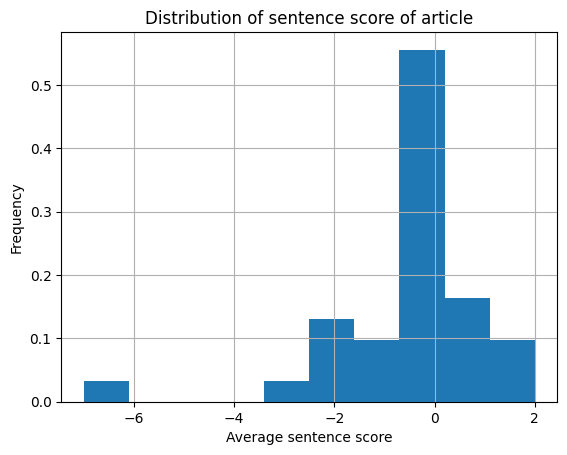

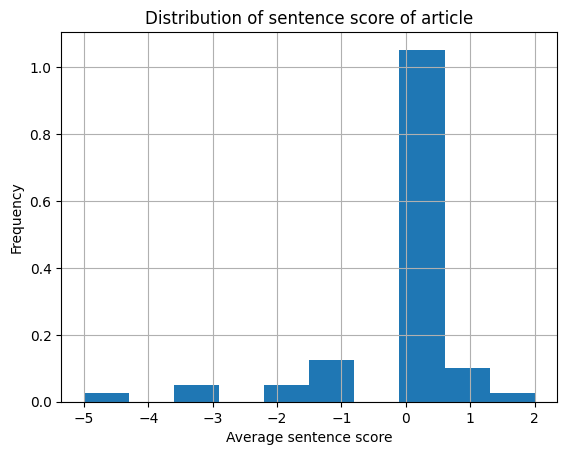

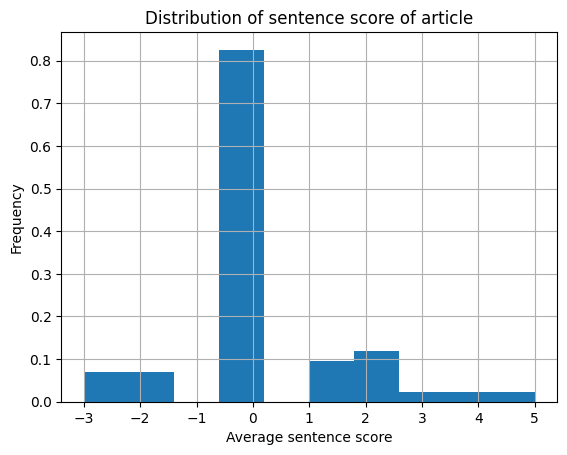

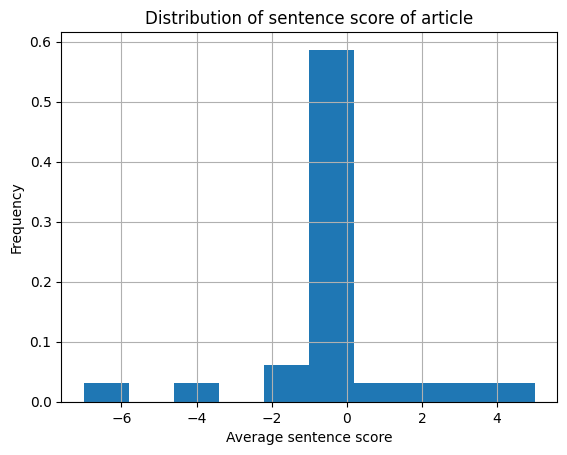

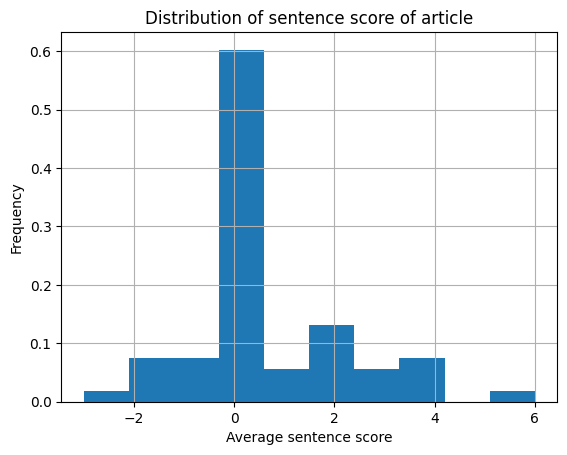

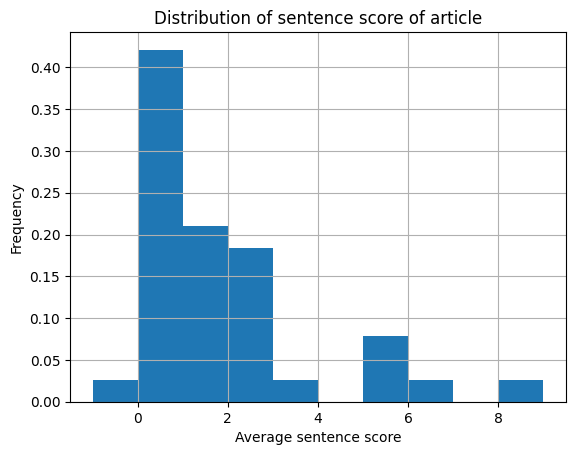

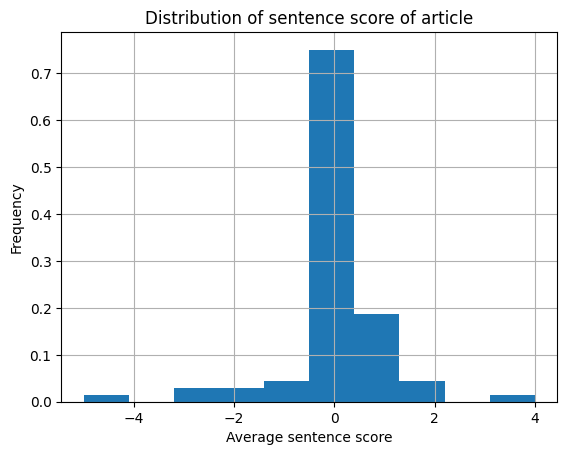

In [76]:
# histogram for each article
for content in articles_df['Contents']:
    sentence_s = []
    sentence_lst = content.split('.') # sentence
    for sentence in sentence_lst:
        sentence_s.append(afinn.score(sentence))
    sentence_Series = pd.Series(sentence_s)
    sentence_Series.hist(density=True)
    plt.xlabel('Average sentence score')
    plt.ylabel('Frequency')
    plt.title('Distribution of sentence score of article')
    plt.show()

In [135]:
# export to csv
articles_df.to_csv("yfinance_Article.csv", index=False)

In [136]:
import pickle
# store the dataframe in pickle
articles_df.to_pickle('yfinance_1106.p')

In [137]:
# read the stored dataframe into a dataframe
articles_df = pd.read_pickle("yfinance_1106.p")  
articles_df

,Title,Link,Author,Date_published,Contents,Ticker,Title_Score,Average_Sentence_Score,Min_Sentence_Score,Max_Sentence_Score,Average_Paragraph_Score,Min_Paragraph_Score,Max_Paragraph_Score,Article_Score
0,How to market a small business on a small budget,https://finance.yahoo.com/news/market-small-bu...,Special to Financial Post,2022-11-05 08:00:00,The pandemic was tough on small businesses in ...,SE,0.0,1.137931,-2.0,6.0,1.571429,-3.0,10.0,33.0
1,Sea Limited to Report Third Quarter 2022 Results,https://finance.yahoo.com/news/sea-limited-rep...,,2022-11-01 02:32:00,"SINGAPORE, November 01, 2022--(BUSINESS WIRE)-...",SE,-1.0,0.258065,-1.0,2.0,0.333333,-1.0,7.0,8.0
2,Sea Limited Sponsored ADR (SE) Gains As Market...,https://finance.yahoo.com/news/sea-limited-spo...,Zacks Equity Research,2022-10-31 17:15:00,Sea Limited Sponsored ADR (SE) closed at $49.6...,SE,1.0,0.414634,-3.0,7.0,1.545455,-7.0,6.0,17.0
3,Ulta Beauty (ULTA) Gains But Lags Market: What...,https://finance.yahoo.com/news/ulta-beauty-ult...,Zacks Equity Research,2022-11-04 16:45:00,"In the latest trading session, Ulta Beauty (UL...",SE,3.0,1.019608,-3.0,7.0,4.333333,0.0,10.0,52.0
4,FREYR Battery (FREY) Stock Sinks As Market Gai...,https://finance.yahoo.com/news/freyr-battery-f...,Zacks Equity Research,2022-11-04 16:50:00,"In the latest trading session, FREYR Battery (...",SE,2.0,0.710526,-3.0,7.0,1.588235,-1.0,7.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,"Yext (YEXT) Reports Q1 Loss, Tops Revenue Esti...",https://finance.yahoo.com/news/yext-yext-repor...,Zacks Equity Research,2022-06-08 00:00:00,Yext (YEXT) came out with a quarterly loss of ...,DOCU,-1.0,0.207547,-3.0,5.0,0.647059,-7.0,7.0,11.0
124,"ECB Decision, Meta Trades, DocuSign Earnings: ...",https://finance.yahoo.com/news/ecb-decision-me...,,2022-06-08 00:00:00,By Liz Moyer\nInvesting.com -- Stocks closed l...,DOCU,0.0,-0.185185,-7.0,5.0,-0.294118,-7.0,3.0,-5.0
125,DocuSign Earnings Preview: What's in Store?,https://finance.yahoo.com/news/docusign-earnin...,Derek Lewis,2022-06-07 00:00:00,The first quarter of 2022 was undoubtedly chal...,DOCU,0.0,0.559322,-3.0,6.0,0.825000,-6.0,7.0,33.0
126,DocuSign and Microsoft Deepen Relationship to ...,https://finance.yahoo.com/news/docusign-micros...,,2022-06-07 00:00:00,The expanded global strategic partnership offe...,DOCU,0.0,1.421053,-1.0,9.0,2.454545,-1.0,9.0,54.0
